In [1]:
# # Code to download file into Colaboratory:
# !pip install -U -q PyDrive > /dev/null
# !pip install torchmetrics > /dev/null
# from pydrive.auth import GoogleAuth
# import torch
# dev = "cuda" if torch.cuda.is_available() else "cpu"
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials
# # Authenticate and create the PyDrive client.
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)

# #get the data from the drive
# def get_feature(model = "ViT-L/14@336px"):
#   id = '11yXddz5j-IDcH77wkMF7dW2JctRv7YN6'
#   size = "B"

#   if model == 'ViT-L/14@336px':
#     id = '1P6CgrgiIACjnhtHsUwdY8qjZ-E3Vx_0x'
#     size = "L336"
#   elif model == 'ViT-L/14':
#     id = '1DG4J-YF57ZsfXTzwg5EFfkzUmUFfr82h'
#     size = "L"
#   elif model == 'ViT-B/32':
#     id = '11yXddz5j-IDcH77wkMF7dW2JctRv7YN6'
#     size = "B"

#   downloaded = drive.CreateFile({'id':id}) 
#   downloaded.GetContentFile('clip_features.zip')

#   #get the data from the drive
#   id = '1b-ujWaLM_jOzlRMbXVb9T-3oEibKQW1r'
#   downloaded = drive.CreateFile({'id':id}) 
#   downloaded.GetContentFile('label_onehot_tensor.pt')

#   !unzip clip_features.zip > /dev/null

#   test_image_features = torch.load(f"test_image_features_vit{size}.pt")
#   test_text_feature = torch.load(f"test_text_feature_vit{size}.pt")
#   all_image_features = torch.load(f"all_image_features_vit{size}.pt")
#   all_text_feature = torch.load(f"all_text_feature_vit{size}.pt")
#   label_onehot_tensor = torch.load(f"label_onehot_tensor.pt")

#   return all_image_features, all_text_feature, test_image_features, test_text_feature, label_onehot_tensor

In [2]:
# all_image_features, all_text_feature, test_image_features, test_text_feature, label_onehot_tensor = get_feature()

In [3]:
# import torch
# dev = "cuda" if torch.cuda.is_available() else "cpu"
# test_image_features = torch.load("test_image_features_vitL.pt", map_location = torch.device(dev))
# test_text_feature = torch.load("test_text_feature_vitL.pt", map_location = torch.device(dev))
# all_image_features = torch.load("all_image_features_vitL.pt", map_location = torch.device(dev))
# all_text_feature = torch.load("all_text_feature_vitL.pt", map_location = torch.device(dev))
# label_onehot_tensor = torch.load("label_onehot_tensor.pt", map_location = torch.device(dev))

In [4]:
import torch
dev = "cuda" if torch.cuda.is_available() else "cpu"
test_image_features = torch.load("../features/test_image_features_vitL.pt", map_location = torch.device(dev))
test_text_feature = torch.load("../features/test_text_feature_vitL.pt", map_location = torch.device(dev))
all_image_features = torch.load("../features/all_image_features_vitL.pt", map_location = torch.device(dev))
all_text_feature = torch.load("../features/all_text_feature_vitL.pt", map_location = torch.device(dev))
label_onehot_tensor = torch.load("../features/label_onehot_tensor.pt", map_location = torch.device(dev))

In [5]:
test_image_features.shape

torch.Size([10000, 768])

In [6]:
def add_weight_decay(model, weight_decay=1e-4, skip_list=()):
    decay = []
    no_decay = []
    for name, param in model.named_parameters():
        if not param.requires_grad:
            continue  # frozen weights
        if len(param.shape) == 1 or name.endswith(".bias") or name in skip_list:
            no_decay.append(param)
        else:
            decay.append(param)
    return [
        {'params': no_decay, 'weight_decay': 0.},
        {'params': decay, 'weight_decay': weight_decay}]

In [7]:
import torch
import torch.nn as nn


class AsymmetricLoss(nn.Module):
    def __init__(self, gamma_neg=4, gamma_pos=1, clip=0.05, eps=1e-8, disable_torch_grad_focal_loss=True):
        super(AsymmetricLoss, self).__init__()

        self.gamma_neg = gamma_neg
        self.gamma_pos = gamma_pos
        self.clip = clip
        self.disable_torch_grad_focal_loss = disable_torch_grad_focal_loss
        self.eps = eps

    def forward(self, x, y):
        """"
        Parameters
        ----------
        x: input logits
        y: targets (multi-label binarized vector)
        """

        # Calculating Probabilities
        
        xs_pos = x
        xs_neg = 1 - x

        # Asymmetric Clipping
        if self.clip is not None and self.clip > 0:
            xs_neg = (xs_neg + self.clip).clamp(max=1)

        # Basic CE calculation
        los_pos = y * torch.log(xs_pos.clamp(min=self.eps))
        los_neg = (1 - y) * torch.log(xs_neg.clamp(min=self.eps))
        loss = los_pos + los_neg

        # Asymmetric Focusing
        if self.gamma_neg > 0 or self.gamma_pos > 0:
            if self.disable_torch_grad_focal_loss:
                torch.set_grad_enabled(False)
            pt0 = xs_pos * y
            pt1 = xs_neg * (1 - y)  # pt = p if t > 0 else 1-p
            pt = pt0 + pt1
            one_sided_gamma = self.gamma_pos * y + self.gamma_neg * (1 - y)
            one_sided_w = torch.pow(1 - pt, one_sided_gamma)
            if self.disable_torch_grad_focal_loss:
                torch.set_grad_enabled(True)
            loss *= one_sided_w

        return -loss.sum()


class AsymmetricLossOptimized(nn.Module):
    ''' Notice - optimized version, minimizes memory allocation and gpu uploading,
    favors inplace operations'''

    def __init__(self, gamma_neg=4, gamma_pos=1, clip=0.05, eps=1e-8, disable_torch_grad_focal_loss=False):
        super(AsymmetricLossOptimized, self).__init__()

        self.gamma_neg = gamma_neg
        self.gamma_pos = gamma_pos
        self.clip = clip
        self.disable_torch_grad_focal_loss = disable_torch_grad_focal_loss
        self.eps = eps
        # prevent memory allocation and gpu uploading every iteration, and encourages inplace operations
        self.targets = self.anti_targets = self.xs_pos = self.xs_neg = self.asymmetric_w = self.loss = None

    def forward(self, x, y):
        """"
        Parameters
        ----------
        x: input logits
        y: targets (multi-label binarized vector)
        """

        self.targets = y
        self.anti_targets = 1 - y

        # Calculating Probabilities
        self.xs_pos = torch.sigmoid(x)
        self.xs_neg = 1.0 - self.xs_pos

        # Asymmetric Clipping
        if self.clip is not None and self.clip > 0:
            self.xs_neg.add_(self.clip).clamp_(max=1)

        # Basic CE calculation
        self.loss = self.targets * torch.log(self.xs_pos.clamp(min=self.eps))
        self.loss.add_(self.anti_targets * torch.log(self.xs_neg.clamp(min=self.eps)))
        
        # Asymmetric Focusing
        if self.gamma_neg > 0 or self.gamma_pos > 0:
            if self.disable_torch_grad_focal_loss:
                torch.set_grad_enabled(False)
            self.xs_pos = self.xs_pos * self.targets
            self.xs_neg = self.xs_neg * self.anti_targets
            self.asymmetric_w = torch.pow(1 - self.xs_pos - self.xs_neg,
                                          self.gamma_pos * self.targets + self.gamma_neg * self.anti_targets)
            if self.disable_torch_grad_focal_loss:
                torch.set_grad_enabled(True)
            self.loss *= self.asymmetric_w

        return -self.loss.sum()

In [8]:
import numpy as np
from tqdm import tqdm
import torch.nn.functional as F
from torchmetrics import F1Score
from torch import optim
from torch.cuda.amp import GradScaler, autocast

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
def Trainer(model, Data, epochs, epoch_step_1, epoch_step_2, lr = 1e-3):
    torch.manual_seed(5329)
    train_data = DataLoader(TensorDataset(Data[:25000], label_onehot_tensor[:25000]), batch_size=25000, shuffle = True)
    val_data = DataLoader(TensorDataset(Data[25000:], label_onehot_tensor[25000:].to(torch.int32)), batch_size=5000, shuffle = False)
    
    # Change here to switch to the best setting
    # train_data = DataLoader(TensorDataset(Data, label_onehot_tensor), batch_size=30000, shuffle = True)
    
    model = model.to(dev)
 
    weight_decay = 2e-4
    criterion = AsymmetricLoss(gamma_neg=0, gamma_pos=0, clip=0, disable_torch_grad_focal_loss=True)
    parameters = add_weight_decay(model, weight_decay)
    opti = optim.Adam(params=parameters, lr=lr, weight_decay=0)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(opti, milestones=[epoch_step_1,epoch_step_2], gamma = 0.1)
    f1 = F1Score(task="multilabel", num_labels = 18).to(dev)

    epoch = epochs
    train_loss = []
    val_loss = []
    f1_list = []
    scaler = GradScaler()
    
    for epoch in tqdm(range(epoch), colour = 'GREEN'):
        for data, label in train_data:   
            data, label = data.to(dev), label.to(dev)

            with autocast():  # mixed precision
                output = model(data).float() 

            loss = criterion(output, label)
            model.zero_grad()
            
            scaler.scale(loss).backward()
            scaler.step(opti)
            scaler.update()
            
        train_loss.append(loss.item())
        
        with torch.autograd.no_grad():
            for data_val, label_val in val_data:
                data_val, label_val = data_val.to(dev), label_val.to(dev)
                predict = model(data_val)
                f1_score = f1(predict, label_val)
                v_loss = criterion(predict, label_val)
            val_loss.append(v_loss.item())
            f1_list.append(f1_score.item())
        
        # Comment the code below if you want to switch to the best settings (i.e., no validation data)
        if epoch % 10 == 0:
            print('Validation F1 in epoch{} : {:.4f}'.format(epoch, f1_score.item()))
            print('Validation loss in epoch{} : {:.4f}'.format(epoch, v_loss.item()))
    
    return model, train_loss, val_loss, f1_list

## Experiments on Activation Functions

In [9]:
import torch.nn as nn
import torch.nn.functional as F
class FEATURE_EXTRACTOR(nn.Module):
    def __init__(self, act:str='gelu'):
        super().__init__()
        self.act = act
        self.fc1 = nn.Linear(768, 2048)
        self.fc2 = nn.Linear(2048, 512)
        self.fc3 = nn.Linear(512, 18)
        self.dropout = nn.Dropout(p = 0.5)

    def forward(self, inputs):
        if self.act == 'gelu':
            tensor = F.gelu(self.fc1(inputs))
            tensor = self.dropout(tensor)
            tensor = F.gelu(self.fc2(tensor))
        elif self.act == 'relu':
            tensor = F.relu(self.fc1(inputs))
            tensor = self.dropout(tensor)
            tensor = F.relu(self.fc2(tensor))
        elif self.act == 'leaky_relu':
            tensor = F.leaky_relu(self.fc1(inputs))
            tensor = self.dropout(tensor)
            tensor = F.leaky_relu(self.fc2(tensor))
        tensor = self.dropout(tensor)
        tensor = torch.sigmoid(self.fc3(tensor))
        return tensor

class DECISION_MODEL(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(18, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 18)

    def forward(self, inputs):
        tensor = F.gelu(self.fc1(inputs))
        tensor = F.gelu(self.fc2(tensor))
        tensor = torch.sigmoid(self.fc3(tensor))
        return tensor

In [10]:
import os
import numpy as np
activation_function = ['gelu','relu','leaky_relu']
mean_list = []
std_list = []
val_loss = []
train_loss = []
for i in range(len(activation_function)):
    f1_list = []
    for j in range(3):
        Net, train_image_loss, val_image_loss, f1_image_list = Trainer(FEATURE_EXTRACTOR(act=activation_function[i]), 
                                                                       all_image_features, 300, 200, 250)
        Net.eval()
        with torch.autograd.no_grad():
            img_train = Net(all_image_features.to(dev))
            img_test = Net(test_image_features.to(dev))

        Net, train_text_loss, val_text_loss, f1_text_list = Trainer(FEATURE_EXTRACTOR(act=activation_function[i]), 
                                                                    all_text_feature, 300, 200, 250)
        Net.eval()
        with torch.autograd.no_grad():
            txt_train = Net(all_text_feature.to(dev))
            txt_test = Net(test_text_feature.to(dev))

        sum_train = img_train + txt_train
        sum_test = img_test + txt_test
        Net, train_sum_loss, val_sum_loss, f1_sum_list = Trainer(DECISION_MODEL(), sum_train, 300, 200, 250)
        Net.eval()
        
        f1_list.append(f1_sum_list[-1])
    
    mean_list.append(np.mean(f1_list))
    std_list.append(np.std(f1_list))
    
    train_loss.append(train_sum_loss)
    val_loss.append(val_sum_loss)
    
print("Mean: ", mean_list)
print('Std: ', std_list)

  0%|▎                                                                                 | 1/300 [00:00<04:51,  1.03it/s]

Validation F1 in epoch0 : 0.1097
Validation loss in epoch0 : 62664.8281


  4%|██▉                                                                              | 11/300 [00:03<01:19,  3.65it/s]

Validation F1 in epoch10 : 0.1108
Validation loss in epoch10 : 62688.5742


  7%|█████▋                                                                           | 21/300 [00:06<01:27,  3.20it/s]

Validation F1 in epoch20 : 0.5847
Validation loss in epoch20 : 22676.9277


 10%|████████▎                                                                        | 31/300 [00:09<01:20,  3.32it/s]

Validation F1 in epoch30 : 0.6144
Validation loss in epoch30 : 15891.6855


 14%|███████████                                                                      | 41/300 [00:12<01:22,  3.15it/s]

Validation F1 in epoch40 : 0.6805
Validation loss in epoch40 : 12157.9668


 17%|█████████████▊                                                                   | 51/300 [00:16<01:21,  3.07it/s]

Validation F1 in epoch50 : 0.7691
Validation loss in epoch50 : 9531.7666


 20%|████████████████▍                                                                | 61/300 [00:19<01:15,  3.15it/s]

Validation F1 in epoch60 : 0.7995
Validation loss in epoch60 : 8326.3350


 24%|███████████████████▏                                                             | 71/300 [00:22<01:07,  3.42it/s]

Validation F1 in epoch70 : 0.8139
Validation loss in epoch70 : 7692.4204


 27%|█████████████████████▊                                                           | 81/300 [00:25<01:04,  3.37it/s]

Validation F1 in epoch80 : 0.8292
Validation loss in epoch80 : 7315.2510


 30%|████████████████████████▌                                                        | 91/300 [00:28<00:59,  3.52it/s]

Validation F1 in epoch90 : 0.8330
Validation loss in epoch90 : 7179.8003


 34%|██████████████████████████▉                                                     | 101/300 [00:31<01:00,  3.27it/s]

Validation F1 in epoch100 : 0.8388
Validation loss in epoch100 : 7071.5029


 37%|█████████████████████████████▌                                                  | 111/300 [00:34<01:01,  3.07it/s]

Validation F1 in epoch110 : 0.8385
Validation loss in epoch110 : 6981.1914


 40%|████████████████████████████████▎                                               | 121/300 [00:37<00:56,  3.17it/s]

Validation F1 in epoch120 : 0.8372
Validation loss in epoch120 : 6899.4038


 44%|██████████████████████████████████▉                                             | 131/300 [00:40<00:51,  3.28it/s]

Validation F1 in epoch130 : 0.8452
Validation loss in epoch130 : 6773.1460


 47%|█████████████████████████████████████▌                                          | 141/300 [00:43<00:47,  3.32it/s]

Validation F1 in epoch140 : 0.8460
Validation loss in epoch140 : 6740.3125


 50%|████████████████████████████████████████▎                                       | 151/300 [00:46<00:43,  3.40it/s]

Validation F1 in epoch150 : 0.8464
Validation loss in epoch150 : 6715.2549


 54%|██████████████████████████████████████████▉                                     | 161/300 [00:50<00:44,  3.11it/s]

Validation F1 in epoch160 : 0.8469
Validation loss in epoch160 : 6677.8496


 57%|█████████████████████████████████████████████▌                                  | 171/300 [00:53<00:38,  3.34it/s]

Validation F1 in epoch170 : 0.8472
Validation loss in epoch170 : 6761.1006


 60%|████████████████████████████████████████████████▎                               | 181/300 [00:56<00:36,  3.25it/s]

Validation F1 in epoch180 : 0.8475
Validation loss in epoch180 : 6715.7368


 64%|██████████████████████████████████████████████████▉                             | 191/300 [00:59<00:35,  3.04it/s]

Validation F1 in epoch190 : 0.8479
Validation loss in epoch190 : 6734.0146


 67%|█████████████████████████████████████████████████████▌                          | 201/300 [01:02<00:30,  3.20it/s]

Validation F1 in epoch200 : 0.8458
Validation loss in epoch200 : 6830.0527


 70%|████████████████████████████████████████████████████████▎                       | 211/300 [01:05<00:25,  3.49it/s]

Validation F1 in epoch210 : 0.8456
Validation loss in epoch210 : 6886.2007


 74%|██████████████████████████████████████████████████████████▉                     | 221/300 [01:08<00:22,  3.48it/s]

Validation F1 in epoch220 : 0.8462
Validation loss in epoch220 : 6979.0562


 77%|█████████████████████████████████████████████████████████████▌                  | 231/300 [01:11<00:21,  3.27it/s]

Validation F1 in epoch230 : 0.8490
Validation loss in epoch230 : 6986.8535


 80%|████████████████████████████████████████████████████████████████▎               | 241/300 [01:14<00:17,  3.35it/s]

Validation F1 in epoch240 : 0.8462
Validation loss in epoch240 : 7148.5767


 84%|██████████████████████████████████████████████████████████████████▉             | 251/300 [01:17<00:16,  3.03it/s]

Validation F1 in epoch250 : 0.8450
Validation loss in epoch250 : 7241.6113


 87%|█████████████████████████████████████████████████████████████████████▌          | 261/300 [01:20<00:12,  3.22it/s]

Validation F1 in epoch260 : 0.8441
Validation loss in epoch260 : 7346.3154


 90%|████████████████████████████████████████████████████████████████████████▎       | 271/300 [01:23<00:09,  2.97it/s]

Validation F1 in epoch270 : 0.8409
Validation loss in epoch270 : 7645.5845


 94%|██████████████████████████████████████████████████████████████████████████▉     | 281/300 [01:26<00:05,  3.31it/s]

Validation F1 in epoch280 : 0.8416
Validation loss in epoch280 : 7805.5459


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 291/300 [01:29<00:02,  3.42it/s]

Validation F1 in epoch290 : 0.8446
Validation loss in epoch290 : 7935.7402


  0%|▎                                                                                 | 1/300 [00:00<01:21,  3.65it/s]

Validation F1 in epoch0 : 0.1727
Validation loss in epoch0 : 62262.7266


  4%|██▉                                                                              | 11/300 [00:03<01:25,  3.38it/s]

Validation F1 in epoch10 : 0.1701
Validation loss in epoch10 : 62268.7734


  7%|█████▋                                                                           | 21/300 [00:06<01:25,  3.26it/s]

Validation F1 in epoch20 : 0.5805
Validation loss in epoch20 : 22970.6152


 10%|████████▎                                                                        | 31/300 [00:09<01:21,  3.29it/s]

Validation F1 in epoch30 : 0.5979
Validation loss in epoch30 : 17531.5645


 14%|███████████                                                                      | 41/300 [00:12<01:17,  3.34it/s]

Validation F1 in epoch40 : 0.6585
Validation loss in epoch40 : 12784.7305


 17%|█████████████▊                                                                   | 51/300 [00:15<01:15,  3.31it/s]

Validation F1 in epoch50 : 0.7597
Validation loss in epoch50 : 10263.7002


 20%|████████████████▍                                                                | 61/300 [00:18<01:09,  3.44it/s]

Validation F1 in epoch60 : 0.7903
Validation loss in epoch60 : 9305.8779


 24%|███████████████████▏                                                             | 71/300 [00:21<01:09,  3.27it/s]

Validation F1 in epoch70 : 0.8050
Validation loss in epoch70 : 8856.1953


 27%|█████████████████████▊                                                           | 81/300 [00:24<01:10,  3.13it/s]

Validation F1 in epoch80 : 0.8104
Validation loss in epoch80 : 8584.6680


 30%|████████████████████████▌                                                        | 91/300 [00:27<01:05,  3.20it/s]

Validation F1 in epoch90 : 0.8146
Validation loss in epoch90 : 8390.0283


 34%|██████████████████████████▉                                                     | 101/300 [00:31<01:01,  3.24it/s]

Validation F1 in epoch100 : 0.8205
Validation loss in epoch100 : 8295.4541


 37%|█████████████████████████████▌                                                  | 111/300 [00:34<00:59,  3.17it/s]

Validation F1 in epoch110 : 0.8197
Validation loss in epoch110 : 8258.9453


 40%|████████████████████████████████▎                                               | 121/300 [00:37<00:52,  3.42it/s]

Validation F1 in epoch120 : 0.8224
Validation loss in epoch120 : 8159.1562


 44%|██████████████████████████████████▉                                             | 131/300 [00:40<00:53,  3.14it/s]

Validation F1 in epoch130 : 0.8209
Validation loss in epoch130 : 8228.5527


 47%|█████████████████████████████████████▌                                          | 141/300 [00:43<00:49,  3.21it/s]

Validation F1 in epoch140 : 0.8234
Validation loss in epoch140 : 8147.2686


 50%|████████████████████████████████████████▎                                       | 151/300 [00:46<00:50,  2.98it/s]

Validation F1 in epoch150 : 0.8225
Validation loss in epoch150 : 8098.5859


 54%|██████████████████████████████████████████▉                                     | 161/300 [00:49<00:42,  3.26it/s]

Validation F1 in epoch160 : 0.8206
Validation loss in epoch160 : 8087.8135


 57%|█████████████████████████████████████████████▌                                  | 171/300 [00:52<00:39,  3.30it/s]

Validation F1 in epoch170 : 0.8217
Validation loss in epoch170 : 8049.8213


 60%|████████████████████████████████████████████████▎                               | 181/300 [00:55<00:37,  3.18it/s]

Validation F1 in epoch180 : 0.8233
Validation loss in epoch180 : 8093.1328


 64%|██████████████████████████████████████████████████▉                             | 191/300 [00:58<00:31,  3.43it/s]

Validation F1 in epoch190 : 0.8248
Validation loss in epoch190 : 8081.6895


 67%|█████████████████████████████████████████████████████▌                          | 201/300 [01:01<00:29,  3.32it/s]

Validation F1 in epoch200 : 0.8240
Validation loss in epoch200 : 8129.9561


 70%|████████████████████████████████████████████████████████▎                       | 211/300 [01:04<00:25,  3.45it/s]

Validation F1 in epoch210 : 0.8243
Validation loss in epoch210 : 8102.6685


 74%|██████████████████████████████████████████████████████████▉                     | 221/300 [01:08<00:24,  3.29it/s]

Validation F1 in epoch220 : 0.8249
Validation loss in epoch220 : 8159.0757


 77%|█████████████████████████████████████████████████████████████▌                  | 231/300 [01:11<00:22,  3.14it/s]

Validation F1 in epoch230 : 0.8245
Validation loss in epoch230 : 8126.0850


 80%|████████████████████████████████████████████████████████████████▎               | 241/300 [01:14<00:18,  3.17it/s]

Validation F1 in epoch240 : 0.8222
Validation loss in epoch240 : 8203.1279


 84%|██████████████████████████████████████████████████████████████████▉             | 251/300 [01:17<00:15,  3.18it/s]

Validation F1 in epoch250 : 0.8190
Validation loss in epoch250 : 8320.3809


 87%|█████████████████████████████████████████████████████████████████████▌          | 261/300 [01:20<00:12,  3.17it/s]

Validation F1 in epoch260 : 0.8203
Validation loss in epoch260 : 8394.3975


 90%|████████████████████████████████████████████████████████████████████████▎       | 271/300 [01:23<00:09,  3.18it/s]

Validation F1 in epoch270 : 0.8181
Validation loss in epoch270 : 8414.2080


 94%|██████████████████████████████████████████████████████████████████████████▉     | 281/300 [01:26<00:05,  3.30it/s]

Validation F1 in epoch280 : 0.8170
Validation loss in epoch280 : 8501.8486


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 291/300 [01:29<00:02,  3.39it/s]

Validation F1 in epoch290 : 0.8166
Validation loss in epoch290 : 8694.2812


  0%|▎                                                                                 | 1/300 [00:00<01:21,  3.65it/s]

Validation F1 in epoch0 : 0.0742
Validation loss in epoch0 : 62219.4336


  4%|██▉                                                                              | 11/300 [00:03<01:28,  3.25it/s]

Validation F1 in epoch10 : 0.0742
Validation loss in epoch10 : 62219.4336


  7%|█████▋                                                                           | 21/300 [00:06<01:47,  2.60it/s]

Validation F1 in epoch20 : 0.5954
Validation loss in epoch20 : 21253.5254


 10%|████████▎                                                                        | 31/300 [00:10<01:26,  3.10it/s]

Validation F1 in epoch30 : 0.6517
Validation loss in epoch30 : 16361.7441


 14%|███████████                                                                      | 41/300 [00:13<01:24,  3.05it/s]

Validation F1 in epoch40 : 0.7520
Validation loss in epoch40 : 11491.9355


 17%|█████████████▊                                                                   | 51/300 [00:16<01:21,  3.04it/s]

Validation F1 in epoch50 : 0.8101
Validation loss in epoch50 : 9287.6152


 20%|████████████████▍                                                                | 61/300 [00:19<01:19,  2.99it/s]

Validation F1 in epoch60 : 0.8341
Validation loss in epoch60 : 7954.6055


 24%|███████████████████▏                                                             | 71/300 [00:23<01:14,  3.08it/s]

Validation F1 in epoch70 : 0.8480
Validation loss in epoch70 : 7396.4102


 27%|█████████████████████▊                                                           | 81/300 [00:26<01:14,  2.95it/s]

Validation F1 in epoch80 : 0.8523
Validation loss in epoch80 : 7191.5664


 30%|████████████████████████▌                                                        | 91/300 [00:29<01:10,  2.96it/s]

Validation F1 in epoch90 : 0.8559
Validation loss in epoch90 : 7203.1436


 34%|██████████████████████████▉                                                     | 101/300 [00:33<01:03,  3.14it/s]

Validation F1 in epoch100 : 0.8583
Validation loss in epoch100 : 7253.1538


 37%|█████████████████████████████▌                                                  | 111/300 [00:36<01:15,  2.50it/s]

Validation F1 in epoch110 : 0.8606
Validation loss in epoch110 : 7377.8467


 40%|████████████████████████████████▎                                               | 121/300 [00:40<00:56,  3.18it/s]

Validation F1 in epoch120 : 0.8618
Validation loss in epoch120 : 7516.3984


 44%|██████████████████████████████████▉                                             | 131/300 [00:43<00:52,  3.22it/s]

Validation F1 in epoch130 : 0.8621
Validation loss in epoch130 : 7682.0146


 47%|█████████████████████████████████████▌                                          | 141/300 [00:46<00:49,  3.22it/s]

Validation F1 in epoch140 : 0.8626
Validation loss in epoch140 : 7851.3599


 50%|████████████████████████████████████████▎                                       | 151/300 [00:49<00:47,  3.11it/s]

Validation F1 in epoch150 : 0.8624
Validation loss in epoch150 : 8015.2305


 54%|██████████████████████████████████████████▉                                     | 161/300 [00:52<00:45,  3.06it/s]

Validation F1 in epoch160 : 0.8628
Validation loss in epoch160 : 8173.2656


 57%|█████████████████████████████████████████████▌                                  | 171/300 [00:55<00:40,  3.19it/s]

Validation F1 in epoch170 : 0.8620
Validation loss in epoch170 : 8322.3643


 60%|████████████████████████████████████████████████▎                               | 181/300 [00:59<00:38,  3.12it/s]

Validation F1 in epoch180 : 0.8612
Validation loss in epoch180 : 8462.7119


 64%|██████████████████████████████████████████████████▉                             | 191/300 [01:02<00:35,  3.08it/s]

Validation F1 in epoch190 : 0.8610
Validation loss in epoch190 : 8593.6240


 67%|█████████████████████████████████████████████████████▌                          | 201/300 [01:05<00:33,  2.99it/s]

Validation F1 in epoch200 : 0.8610
Validation loss in epoch200 : 8715.7148


 70%|████████████████████████████████████████████████████████▎                       | 211/300 [01:09<00:31,  2.83it/s]

Validation F1 in epoch210 : 0.8607
Validation loss in epoch210 : 8830.6104


 74%|██████████████████████████████████████████████████████████▉                     | 221/300 [01:12<00:28,  2.82it/s]

Validation F1 in epoch220 : 0.8607
Validation loss in epoch220 : 8937.6084


 77%|█████████████████████████████████████████████████████████████▌                  | 231/300 [01:15<00:24,  2.84it/s]

Validation F1 in epoch230 : 0.8604
Validation loss in epoch230 : 9036.5371


 80%|████████████████████████████████████████████████████████████████▎               | 241/300 [01:18<00:17,  3.30it/s]

Validation F1 in epoch240 : 0.8603
Validation loss in epoch240 : 9127.8027


 84%|██████████████████████████████████████████████████████████████████▉             | 251/300 [01:22<00:14,  3.37it/s]

Validation F1 in epoch250 : 0.8603
Validation loss in epoch250 : 9212.3613


 87%|█████████████████████████████████████████████████████████████████████▌          | 261/300 [01:25<00:11,  3.35it/s]

Validation F1 in epoch260 : 0.8601
Validation loss in epoch260 : 9290.7070


 90%|████████████████████████████████████████████████████████████████████████▎       | 271/300 [01:28<00:08,  3.25it/s]

Validation F1 in epoch270 : 0.8601
Validation loss in epoch270 : 9361.9434


 94%|██████████████████████████████████████████████████████████████████████████▉     | 281/300 [01:31<00:05,  3.24it/s]

Validation F1 in epoch280 : 0.8601
Validation loss in epoch280 : 9429.5977


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 291/300 [01:34<00:02,  3.20it/s]

Validation F1 in epoch290 : 0.8601
Validation loss in epoch290 : 9489.3584


  0%|▎                                                                                 | 1/300 [00:00<02:00,  2.48it/s]

Validation F1 in epoch0 : 0.1948
Validation loss in epoch0 : 62050.1797


  4%|██▉                                                                              | 11/300 [00:03<01:23,  3.47it/s]

Validation F1 in epoch10 : 0.1925
Validation loss in epoch10 : 62037.9922


  7%|█████▋                                                                           | 21/300 [00:06<01:23,  3.33it/s]

Validation F1 in epoch20 : 0.5179
Validation loss in epoch20 : 23711.9766


 10%|████████▎                                                                        | 31/300 [00:09<01:18,  3.43it/s]

Validation F1 in epoch30 : 0.6429
Validation loss in epoch30 : 16490.4414


 14%|███████████                                                                      | 41/300 [00:12<01:24,  3.08it/s]

Validation F1 in epoch40 : 0.6927
Validation loss in epoch40 : 11454.8652


 17%|█████████████▊                                                                   | 51/300 [00:15<01:14,  3.33it/s]

Validation F1 in epoch50 : 0.7752
Validation loss in epoch50 : 9145.8984


 20%|████████████████▍                                                                | 61/300 [00:18<01:13,  3.25it/s]

Validation F1 in epoch60 : 0.8021
Validation loss in epoch60 : 8138.5776


 24%|███████████████████▏                                                             | 71/300 [00:21<01:19,  2.89it/s]

Validation F1 in epoch70 : 0.8208
Validation loss in epoch70 : 7609.6260


 27%|█████████████████████▊                                                           | 81/300 [00:24<01:06,  3.30it/s]

Validation F1 in epoch80 : 0.8274
Validation loss in epoch80 : 7328.0488


 30%|████████████████████████▌                                                        | 91/300 [00:27<01:02,  3.34it/s]

Validation F1 in epoch90 : 0.8343
Validation loss in epoch90 : 7075.3271


 34%|██████████████████████████▉                                                     | 101/300 [00:30<00:58,  3.42it/s]

Validation F1 in epoch100 : 0.8376
Validation loss in epoch100 : 6994.2612


 37%|█████████████████████████████▌                                                  | 111/300 [00:33<00:57,  3.29it/s]

Validation F1 in epoch110 : 0.8399
Validation loss in epoch110 : 6909.9419


 40%|████████████████████████████████▎                                               | 121/300 [00:37<00:56,  3.17it/s]

Validation F1 in epoch120 : 0.8430
Validation loss in epoch120 : 6802.5825


 44%|██████████████████████████████████▉                                             | 131/300 [00:40<00:51,  3.29it/s]

Validation F1 in epoch130 : 0.8463
Validation loss in epoch130 : 6766.9116


 47%|█████████████████████████████████████▌                                          | 141/300 [00:43<00:51,  3.07it/s]

Validation F1 in epoch140 : 0.8435
Validation loss in epoch140 : 6811.2061


 50%|████████████████████████████████████████▎                                       | 151/300 [00:47<00:49,  2.98it/s]

Validation F1 in epoch150 : 0.8493
Validation loss in epoch150 : 6679.8867


 54%|██████████████████████████████████████████▉                                     | 161/300 [00:50<00:44,  3.13it/s]

Validation F1 in epoch160 : 0.8457
Validation loss in epoch160 : 6715.9160


 57%|█████████████████████████████████████████████▌                                  | 171/300 [00:53<00:39,  3.29it/s]

Validation F1 in epoch170 : 0.8482
Validation loss in epoch170 : 6616.6084


 60%|████████████████████████████████████████████████▎                               | 181/300 [00:56<00:39,  2.98it/s]

Validation F1 in epoch180 : 0.8485
Validation loss in epoch180 : 6680.3960


 64%|██████████████████████████████████████████████████▉                             | 191/300 [00:59<00:33,  3.24it/s]

Validation F1 in epoch190 : 0.8474
Validation loss in epoch190 : 6792.7490


 67%|█████████████████████████████████████████████████████▌                          | 201/300 [01:02<00:29,  3.30it/s]

Validation F1 in epoch200 : 0.8456
Validation loss in epoch200 : 6821.7524


 70%|████████████████████████████████████████████████████████▎                       | 211/300 [01:05<00:28,  3.07it/s]

Validation F1 in epoch210 : 0.8487
Validation loss in epoch210 : 6870.5488


 74%|██████████████████████████████████████████████████████████▉                     | 221/300 [01:08<00:22,  3.45it/s]

Validation F1 in epoch220 : 0.8446
Validation loss in epoch220 : 6991.7822


 77%|█████████████████████████████████████████████████████████████▌                  | 231/300 [01:12<00:20,  3.31it/s]

Validation F1 in epoch230 : 0.8448
Validation loss in epoch230 : 7085.3901


 80%|████████████████████████████████████████████████████████████████▎               | 241/300 [01:15<00:18,  3.16it/s]

Validation F1 in epoch240 : 0.8449
Validation loss in epoch240 : 7197.8818


 84%|██████████████████████████████████████████████████████████████████▉             | 251/300 [01:18<00:15,  3.21it/s]

Validation F1 in epoch250 : 0.8439
Validation loss in epoch250 : 7386.1089


 87%|█████████████████████████████████████████████████████████████████████▌          | 261/300 [01:21<00:11,  3.33it/s]

Validation F1 in epoch260 : 0.8428
Validation loss in epoch260 : 7494.7158


 90%|████████████████████████████████████████████████████████████████████████▎       | 271/300 [01:24<00:09,  3.12it/s]

Validation F1 in epoch270 : 0.8421
Validation loss in epoch270 : 7633.8115


 94%|██████████████████████████████████████████████████████████████████████████▉     | 281/300 [01:27<00:05,  3.35it/s]

Validation F1 in epoch280 : 0.8407
Validation loss in epoch280 : 7856.1533


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 291/300 [01:30<00:03,  2.96it/s]

Validation F1 in epoch290 : 0.8389
Validation loss in epoch290 : 8089.2812


  0%|▎                                                                                 | 1/300 [00:00<01:20,  3.70it/s]

Validation F1 in epoch0 : 0.1727
Validation loss in epoch0 : 62262.7266


  4%|██▉                                                                              | 11/300 [00:03<01:29,  3.24it/s]

Validation F1 in epoch10 : 0.1701
Validation loss in epoch10 : 62268.7734


  7%|█████▋                                                                           | 21/300 [00:06<01:25,  3.28it/s]

Validation F1 in epoch20 : 0.5805
Validation loss in epoch20 : 22970.6152


 10%|████████▎                                                                        | 31/300 [00:09<01:33,  2.88it/s]

Validation F1 in epoch30 : 0.5979
Validation loss in epoch30 : 17531.5645


 14%|███████████                                                                      | 41/300 [00:12<01:20,  3.21it/s]

Validation F1 in epoch40 : 0.6585
Validation loss in epoch40 : 12784.7305


 17%|█████████████▊                                                                   | 51/300 [00:15<01:16,  3.25it/s]

Validation F1 in epoch50 : 0.7597
Validation loss in epoch50 : 10263.7002


 20%|████████████████▍                                                                | 61/300 [00:18<01:10,  3.39it/s]

Validation F1 in epoch60 : 0.7903
Validation loss in epoch60 : 9305.8779


 24%|███████████████████▏                                                             | 71/300 [00:21<01:10,  3.24it/s]

Validation F1 in epoch70 : 0.8050
Validation loss in epoch70 : 8856.1953


 27%|█████████████████████▊                                                           | 81/300 [00:24<01:07,  3.22it/s]

Validation F1 in epoch80 : 0.8104
Validation loss in epoch80 : 8584.6680


 30%|████████████████████████▌                                                        | 91/300 [00:28<01:03,  3.31it/s]

Validation F1 in epoch90 : 0.8146
Validation loss in epoch90 : 8390.0283


 34%|██████████████████████████▉                                                     | 101/300 [00:31<01:01,  3.23it/s]

Validation F1 in epoch100 : 0.8205
Validation loss in epoch100 : 8295.4541


 37%|█████████████████████████████▌                                                  | 111/300 [00:34<01:00,  3.14it/s]

Validation F1 in epoch110 : 0.8197
Validation loss in epoch110 : 8258.9453


 40%|████████████████████████████████▎                                               | 121/300 [00:37<00:55,  3.24it/s]

Validation F1 in epoch120 : 0.8224
Validation loss in epoch120 : 8159.1562


 44%|██████████████████████████████████▉                                             | 131/300 [00:40<00:52,  3.19it/s]

Validation F1 in epoch130 : 0.8209
Validation loss in epoch130 : 8228.5527


 47%|█████████████████████████████████████▌                                          | 141/300 [00:43<00:52,  3.03it/s]

Validation F1 in epoch140 : 0.8234
Validation loss in epoch140 : 8147.2686


 50%|████████████████████████████████████████▎                                       | 151/300 [00:46<00:45,  3.27it/s]

Validation F1 in epoch150 : 0.8225
Validation loss in epoch150 : 8098.5859


 54%|██████████████████████████████████████████▉                                     | 161/300 [00:49<00:45,  3.03it/s]

Validation F1 in epoch160 : 0.8206
Validation loss in epoch160 : 8087.8135


 57%|█████████████████████████████████████████████▌                                  | 171/300 [00:52<00:40,  3.19it/s]

Validation F1 in epoch170 : 0.8217
Validation loss in epoch170 : 8049.8213


 60%|████████████████████████████████████████████████▎                               | 181/300 [00:56<00:39,  3.03it/s]

Validation F1 in epoch180 : 0.8233
Validation loss in epoch180 : 8093.1328


 64%|██████████████████████████████████████████████████▉                             | 191/300 [00:59<00:33,  3.26it/s]

Validation F1 in epoch190 : 0.8248
Validation loss in epoch190 : 8081.6895


 67%|█████████████████████████████████████████████████████▌                          | 201/300 [01:02<00:29,  3.40it/s]

Validation F1 in epoch200 : 0.8240
Validation loss in epoch200 : 8129.9561


 70%|████████████████████████████████████████████████████████▎                       | 211/300 [01:05<00:27,  3.21it/s]

Validation F1 in epoch210 : 0.8243
Validation loss in epoch210 : 8102.6685


 74%|██████████████████████████████████████████████████████████▉                     | 221/300 [01:08<00:23,  3.38it/s]

Validation F1 in epoch220 : 0.8249
Validation loss in epoch220 : 8159.0757


 77%|█████████████████████████████████████████████████████████████▌                  | 231/300 [01:11<00:21,  3.16it/s]

Validation F1 in epoch230 : 0.8245
Validation loss in epoch230 : 8126.0850


 80%|████████████████████████████████████████████████████████████████▎               | 241/300 [01:14<00:17,  3.33it/s]

Validation F1 in epoch240 : 0.8222
Validation loss in epoch240 : 8203.1279


 84%|██████████████████████████████████████████████████████████████████▉             | 251/300 [01:17<00:15,  3.11it/s]

Validation F1 in epoch250 : 0.8190
Validation loss in epoch250 : 8320.3809


 87%|█████████████████████████████████████████████████████████████████████▌          | 261/300 [01:21<00:12,  3.13it/s]

Validation F1 in epoch260 : 0.8203
Validation loss in epoch260 : 8394.3975


 90%|████████████████████████████████████████████████████████████████████████▎       | 271/300 [01:24<00:09,  3.11it/s]

Validation F1 in epoch270 : 0.8181
Validation loss in epoch270 : 8414.2080


 94%|██████████████████████████████████████████████████████████████████████████▉     | 281/300 [01:27<00:05,  3.23it/s]

Validation F1 in epoch280 : 0.8170
Validation loss in epoch280 : 8501.8486


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 291/300 [01:30<00:02,  3.34it/s]

Validation F1 in epoch290 : 0.8166
Validation loss in epoch290 : 8694.2812


  0%|▎                                                                                 | 1/300 [00:00<01:19,  3.76it/s]

Validation F1 in epoch0 : 0.0736
Validation loss in epoch0 : 62219.4531


  4%|██▉                                                                              | 11/300 [00:03<01:29,  3.23it/s]

Validation F1 in epoch10 : 0.0736
Validation loss in epoch10 : 62219.4531


  7%|█████▋                                                                           | 21/300 [00:06<01:27,  3.19it/s]

Validation F1 in epoch20 : 0.5955
Validation loss in epoch20 : 21254.6660


 10%|████████▎                                                                        | 31/300 [00:09<01:24,  3.19it/s]

Validation F1 in epoch30 : 0.6528
Validation loss in epoch30 : 16334.5938


 14%|███████████                                                                      | 41/300 [00:12<01:19,  3.26it/s]

Validation F1 in epoch40 : 0.7501
Validation loss in epoch40 : 11456.4473


 17%|█████████████▊                                                                   | 51/300 [00:15<01:15,  3.30it/s]

Validation F1 in epoch50 : 0.8110
Validation loss in epoch50 : 9257.3730


 20%|████████████████▍                                                                | 61/300 [00:18<01:12,  3.28it/s]

Validation F1 in epoch60 : 0.8327
Validation loss in epoch60 : 7937.9141


 24%|███████████████████▏                                                             | 71/300 [00:21<01:10,  3.24it/s]

Validation F1 in epoch70 : 0.8461
Validation loss in epoch70 : 7399.3120


 27%|█████████████████████▊                                                           | 81/300 [00:24<01:07,  3.23it/s]

Validation F1 in epoch80 : 0.8522
Validation loss in epoch80 : 7217.2471


 30%|████████████████████████▌                                                        | 91/300 [00:27<01:06,  3.16it/s]

Validation F1 in epoch90 : 0.8566
Validation loss in epoch90 : 7245.0181


 34%|██████████████████████████▉                                                     | 101/300 [00:31<01:02,  3.17it/s]

Validation F1 in epoch100 : 0.8588
Validation loss in epoch100 : 7310.2368


 37%|█████████████████████████████▌                                                  | 111/300 [00:34<00:54,  3.49it/s]

Validation F1 in epoch110 : 0.8608
Validation loss in epoch110 : 7442.9141


 40%|████████████████████████████████▎                                               | 121/300 [00:37<00:54,  3.30it/s]

Validation F1 in epoch120 : 0.8614
Validation loss in epoch120 : 7587.7495


 44%|██████████████████████████████████▉                                             | 131/300 [00:40<00:51,  3.31it/s]

Validation F1 in epoch130 : 0.8628
Validation loss in epoch130 : 7759.2852


 47%|█████████████████████████████████████▌                                          | 141/300 [00:43<00:49,  3.23it/s]

Validation F1 in epoch140 : 0.8624
Validation loss in epoch140 : 7933.7109


 50%|████████████████████████████████████████▎                                       | 151/300 [00:46<00:44,  3.36it/s]

Validation F1 in epoch150 : 0.8630
Validation loss in epoch150 : 8105.8257


 54%|██████████████████████████████████████████▉                                     | 161/300 [00:49<00:44,  3.14it/s]

Validation F1 in epoch160 : 0.8632
Validation loss in epoch160 : 8269.4014


 57%|█████████████████████████████████████████████▌                                  | 171/300 [00:52<00:40,  3.18it/s]

Validation F1 in epoch170 : 0.8626
Validation loss in epoch170 : 8425.6641


 60%|████████████████████████████████████████████████▎                               | 181/300 [00:55<00:34,  3.41it/s]

Validation F1 in epoch180 : 0.8625
Validation loss in epoch180 : 8571.4092


 64%|██████████████████████████████████████████████████▉                             | 191/300 [00:58<00:32,  3.31it/s]

Validation F1 in epoch190 : 0.8620
Validation loss in epoch190 : 8708.6953


 67%|█████████████████████████████████████████████████████▌                          | 201/300 [01:01<00:32,  3.04it/s]

Validation F1 in epoch200 : 0.8617
Validation loss in epoch200 : 8836.8301


 70%|████████████████████████████████████████████████████████▎                       | 211/300 [01:04<00:28,  3.16it/s]

Validation F1 in epoch210 : 0.8616
Validation loss in epoch210 : 8958.2402


 74%|██████████████████████████████████████████████████████████▉                     | 221/300 [01:07<00:25,  3.14it/s]

Validation F1 in epoch220 : 0.8613
Validation loss in epoch220 : 9072.2832


 77%|█████████████████████████████████████████████████████████████▌                  | 231/300 [01:10<00:21,  3.22it/s]

Validation F1 in epoch230 : 0.8615
Validation loss in epoch230 : 9177.8281


 80%|████████████████████████████████████████████████████████████████▎               | 241/300 [01:13<00:18,  3.18it/s]

Validation F1 in epoch240 : 0.8614
Validation loss in epoch240 : 9275.9082


 84%|██████████████████████████████████████████████████████████████████▉             | 251/300 [01:17<00:14,  3.35it/s]

Validation F1 in epoch250 : 0.8611
Validation loss in epoch250 : 9365.7891


 87%|█████████████████████████████████████████████████████████████████████▌          | 261/300 [01:20<00:12,  3.22it/s]

Validation F1 in epoch260 : 0.8611
Validation loss in epoch260 : 9449.8203


 90%|████████████████████████████████████████████████████████████████████████▎       | 271/300 [01:23<00:08,  3.25it/s]

Validation F1 in epoch270 : 0.8610
Validation loss in epoch270 : 9525.6455


 94%|██████████████████████████████████████████████████████████████████████████▉     | 281/300 [01:26<00:06,  3.05it/s]

Validation F1 in epoch280 : 0.8608
Validation loss in epoch280 : 9597.0391


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 291/300 [01:29<00:02,  3.23it/s]

Validation F1 in epoch290 : 0.8609
Validation loss in epoch290 : 9662.8818


  0%|▎                                                                                 | 1/300 [00:00<02:01,  2.46it/s]

Validation F1 in epoch0 : 0.1948
Validation loss in epoch0 : 62050.1797


  4%|██▉                                                                              | 11/300 [00:03<01:28,  3.25it/s]

Validation F1 in epoch10 : 0.1925
Validation loss in epoch10 : 62037.9922


  7%|█████▋                                                                           | 21/300 [00:06<01:35,  2.93it/s]

Validation F1 in epoch20 : 0.5179
Validation loss in epoch20 : 23711.9766


 10%|████████▎                                                                        | 31/300 [00:09<01:23,  3.21it/s]

Validation F1 in epoch30 : 0.6429
Validation loss in epoch30 : 16490.4414


 14%|███████████                                                                      | 41/300 [00:12<01:19,  3.25it/s]

Validation F1 in epoch40 : 0.6927
Validation loss in epoch40 : 11454.8652


 17%|█████████████▊                                                                   | 51/300 [00:16<01:21,  3.06it/s]

Validation F1 in epoch50 : 0.7752
Validation loss in epoch50 : 9145.8984


 20%|████████████████▍                                                                | 61/300 [00:19<01:16,  3.12it/s]

Validation F1 in epoch60 : 0.8021
Validation loss in epoch60 : 8138.5776


 24%|███████████████████▏                                                             | 71/300 [00:22<01:12,  3.16it/s]

Validation F1 in epoch70 : 0.8208
Validation loss in epoch70 : 7609.6260


 27%|█████████████████████▊                                                           | 81/300 [00:25<01:19,  2.76it/s]

Validation F1 in epoch80 : 0.8274
Validation loss in epoch80 : 7328.0488


 30%|████████████████████████▌                                                        | 91/300 [00:28<01:04,  3.23it/s]

Validation F1 in epoch90 : 0.8343
Validation loss in epoch90 : 7075.3271


 34%|██████████████████████████▉                                                     | 101/300 [00:31<01:00,  3.31it/s]

Validation F1 in epoch100 : 0.8376
Validation loss in epoch100 : 6994.2612


 37%|█████████████████████████████▌                                                  | 111/300 [00:34<00:58,  3.22it/s]

Validation F1 in epoch110 : 0.8399
Validation loss in epoch110 : 6909.9419


 40%|████████████████████████████████▎                                               | 121/300 [00:38<00:55,  3.25it/s]

Validation F1 in epoch120 : 0.8430
Validation loss in epoch120 : 6802.5825


 44%|██████████████████████████████████▉                                             | 131/300 [00:41<00:53,  3.16it/s]

Validation F1 in epoch130 : 0.8463
Validation loss in epoch130 : 6766.9116


 47%|█████████████████████████████████████▌                                          | 141/300 [00:44<00:51,  3.10it/s]

Validation F1 in epoch140 : 0.8435
Validation loss in epoch140 : 6811.2061


 50%|████████████████████████████████████████▎                                       | 151/300 [00:47<00:53,  2.77it/s]

Validation F1 in epoch150 : 0.8493
Validation loss in epoch150 : 6679.8867


 54%|██████████████████████████████████████████▉                                     | 161/300 [00:50<00:41,  3.35it/s]

Validation F1 in epoch160 : 0.8457
Validation loss in epoch160 : 6715.9160


 57%|█████████████████████████████████████████████▌                                  | 171/300 [00:53<00:40,  3.20it/s]

Validation F1 in epoch170 : 0.8482
Validation loss in epoch170 : 6616.6084


 60%|████████████████████████████████████████████████▎                               | 181/300 [00:57<00:35,  3.32it/s]

Validation F1 in epoch180 : 0.8485
Validation loss in epoch180 : 6680.3960


 64%|██████████████████████████████████████████████████▉                             | 191/300 [01:00<00:34,  3.14it/s]

Validation F1 in epoch190 : 0.8474
Validation loss in epoch190 : 6792.7490


 67%|█████████████████████████████████████████████████████▌                          | 201/300 [01:03<00:30,  3.21it/s]

Validation F1 in epoch200 : 0.8456
Validation loss in epoch200 : 6821.7524


 70%|████████████████████████████████████████████████████████▎                       | 211/300 [01:06<00:28,  3.09it/s]

Validation F1 in epoch210 : 0.8487
Validation loss in epoch210 : 6870.5488


 74%|██████████████████████████████████████████████████████████▉                     | 221/300 [01:09<00:25,  3.13it/s]

Validation F1 in epoch220 : 0.8446
Validation loss in epoch220 : 6991.7822


 77%|█████████████████████████████████████████████████████████████▌                  | 231/300 [01:12<00:21,  3.27it/s]

Validation F1 in epoch230 : 0.8448
Validation loss in epoch230 : 7085.3901


 80%|████████████████████████████████████████████████████████████████▎               | 241/300 [01:16<00:18,  3.16it/s]

Validation F1 in epoch240 : 0.8449
Validation loss in epoch240 : 7197.8818


 84%|██████████████████████████████████████████████████████████████████▉             | 251/300 [01:19<00:14,  3.29it/s]

Validation F1 in epoch250 : 0.8439
Validation loss in epoch250 : 7386.1089


 87%|█████████████████████████████████████████████████████████████████████▌          | 261/300 [01:22<00:12,  3.08it/s]

Validation F1 in epoch260 : 0.8428
Validation loss in epoch260 : 7494.7158


 90%|████████████████████████████████████████████████████████████████████████▎       | 271/300 [01:25<00:09,  3.17it/s]

Validation F1 in epoch270 : 0.8421
Validation loss in epoch270 : 7633.8115


 94%|██████████████████████████████████████████████████████████████████████████▉     | 281/300 [01:29<00:06,  3.11it/s]

Validation F1 in epoch280 : 0.8407
Validation loss in epoch280 : 7856.1533


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 291/300 [01:32<00:02,  3.13it/s]

Validation F1 in epoch290 : 0.8389
Validation loss in epoch290 : 8089.2812


  0%|▎                                                                                 | 1/300 [00:00<01:24,  3.55it/s]

Validation F1 in epoch0 : 0.1727
Validation loss in epoch0 : 62262.7266


  4%|██▉                                                                              | 11/300 [00:03<01:26,  3.32it/s]

Validation F1 in epoch10 : 0.1701
Validation loss in epoch10 : 62268.7734


  7%|█████▋                                                                           | 21/300 [00:06<01:25,  3.26it/s]

Validation F1 in epoch20 : 0.5805
Validation loss in epoch20 : 22970.6152


 10%|████████▎                                                                        | 31/300 [00:09<01:19,  3.38it/s]

Validation F1 in epoch30 : 0.5979
Validation loss in epoch30 : 17531.5645


 14%|███████████                                                                      | 41/300 [00:12<01:21,  3.17it/s]

Validation F1 in epoch40 : 0.6585
Validation loss in epoch40 : 12784.7305


 17%|█████████████▊                                                                   | 51/300 [00:15<01:18,  3.16it/s]

Validation F1 in epoch50 : 0.7597
Validation loss in epoch50 : 10263.7002


 20%|████████████████▍                                                                | 61/300 [00:19<01:23,  2.86it/s]

Validation F1 in epoch60 : 0.7903
Validation loss in epoch60 : 9305.8779


 24%|███████████████████▏                                                             | 71/300 [00:22<01:07,  3.37it/s]

Validation F1 in epoch70 : 0.8050
Validation loss in epoch70 : 8856.1953


 27%|█████████████████████▊                                                           | 81/300 [00:25<01:06,  3.31it/s]

Validation F1 in epoch80 : 0.8104
Validation loss in epoch80 : 8584.6680


 30%|████████████████████████▌                                                        | 91/300 [00:28<01:13,  2.86it/s]

Validation F1 in epoch90 : 0.8146
Validation loss in epoch90 : 8390.0283


 34%|██████████████████████████▉                                                     | 101/300 [00:31<01:01,  3.22it/s]

Validation F1 in epoch100 : 0.8205
Validation loss in epoch100 : 8295.4541


 37%|█████████████████████████████▌                                                  | 111/300 [00:34<00:58,  3.26it/s]

Validation F1 in epoch110 : 0.8197
Validation loss in epoch110 : 8258.9453


 40%|████████████████████████████████▎                                               | 121/300 [00:37<00:57,  3.13it/s]

Validation F1 in epoch120 : 0.8224
Validation loss in epoch120 : 8159.1562


 44%|██████████████████████████████████▉                                             | 131/300 [00:41<00:53,  3.15it/s]

Validation F1 in epoch130 : 0.8209
Validation loss in epoch130 : 8228.5527


 47%|█████████████████████████████████████▌                                          | 141/300 [00:44<00:48,  3.30it/s]

Validation F1 in epoch140 : 0.8234
Validation loss in epoch140 : 8147.2686


 50%|████████████████████████████████████████▎                                       | 151/300 [00:47<00:49,  2.99it/s]

Validation F1 in epoch150 : 0.8225
Validation loss in epoch150 : 8098.5859


 54%|██████████████████████████████████████████▉                                     | 161/300 [00:50<00:42,  3.24it/s]

Validation F1 in epoch160 : 0.8206
Validation loss in epoch160 : 8087.8135


 57%|█████████████████████████████████████████████▌                                  | 171/300 [00:53<00:39,  3.25it/s]

Validation F1 in epoch170 : 0.8217
Validation loss in epoch170 : 8049.8213


 60%|████████████████████████████████████████████████▎                               | 181/300 [00:56<00:37,  3.13it/s]

Validation F1 in epoch180 : 0.8233
Validation loss in epoch180 : 8093.1328


 64%|██████████████████████████████████████████████████▉                             | 191/300 [00:59<00:34,  3.17it/s]

Validation F1 in epoch190 : 0.8248
Validation loss in epoch190 : 8081.6895


 67%|█████████████████████████████████████████████████████▌                          | 201/300 [01:03<00:32,  3.02it/s]

Validation F1 in epoch200 : 0.8240
Validation loss in epoch200 : 8129.9561


 70%|████████████████████████████████████████████████████████▎                       | 211/300 [01:06<00:27,  3.26it/s]

Validation F1 in epoch210 : 0.8243
Validation loss in epoch210 : 8102.6685


 74%|██████████████████████████████████████████████████████████▉                     | 221/300 [01:09<00:23,  3.32it/s]

Validation F1 in epoch220 : 0.8249
Validation loss in epoch220 : 8159.0757


 77%|█████████████████████████████████████████████████████████████▌                  | 231/300 [01:12<00:21,  3.24it/s]

Validation F1 in epoch230 : 0.8245
Validation loss in epoch230 : 8126.0850


 80%|████████████████████████████████████████████████████████████████▎               | 241/300 [01:15<00:17,  3.35it/s]

Validation F1 in epoch240 : 0.8222
Validation loss in epoch240 : 8203.1279


 84%|██████████████████████████████████████████████████████████████████▉             | 251/300 [01:18<00:14,  3.27it/s]

Validation F1 in epoch250 : 0.8190
Validation loss in epoch250 : 8320.3809


 87%|█████████████████████████████████████████████████████████████████████▌          | 261/300 [01:21<00:12,  3.13it/s]

Validation F1 in epoch260 : 0.8203
Validation loss in epoch260 : 8394.3975


 90%|████████████████████████████████████████████████████████████████████████▎       | 271/300 [01:24<00:08,  3.24it/s]

Validation F1 in epoch270 : 0.8181
Validation loss in epoch270 : 8414.2080


 94%|██████████████████████████████████████████████████████████████████████████▉     | 281/300 [01:27<00:05,  3.28it/s]

Validation F1 in epoch280 : 0.8170
Validation loss in epoch280 : 8501.8486


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 291/300 [01:30<00:02,  3.26it/s]

Validation F1 in epoch290 : 0.8166
Validation loss in epoch290 : 8694.2812


  0%|▎                                                                                 | 1/300 [00:00<01:15,  3.95it/s]

Validation F1 in epoch0 : 0.0736
Validation loss in epoch0 : 62219.4531


  4%|██▉                                                                              | 11/300 [00:03<01:29,  3.22it/s]

Validation F1 in epoch10 : 0.0736
Validation loss in epoch10 : 62219.4531


  7%|█████▋                                                                           | 21/300 [00:06<01:29,  3.11it/s]

Validation F1 in epoch20 : 0.5955
Validation loss in epoch20 : 21254.6660


 10%|████████▎                                                                        | 31/300 [00:09<01:27,  3.07it/s]

Validation F1 in epoch30 : 0.6528
Validation loss in epoch30 : 16334.5938


 14%|███████████                                                                      | 41/300 [00:12<01:22,  3.15it/s]

Validation F1 in epoch40 : 0.7501
Validation loss in epoch40 : 11456.4473


 17%|█████████████▊                                                                   | 51/300 [00:15<01:14,  3.33it/s]

Validation F1 in epoch50 : 0.8110
Validation loss in epoch50 : 9257.3730


 20%|████████████████▍                                                                | 61/300 [00:18<01:13,  3.27it/s]

Validation F1 in epoch60 : 0.8327
Validation loss in epoch60 : 7937.9141


 24%|███████████████████▏                                                             | 71/300 [00:21<01:10,  3.26it/s]

Validation F1 in epoch70 : 0.8461
Validation loss in epoch70 : 7399.3120


 27%|█████████████████████▊                                                           | 81/300 [00:25<01:07,  3.23it/s]

Validation F1 in epoch80 : 0.8522
Validation loss in epoch80 : 7217.2471


 30%|████████████████████████▌                                                        | 91/300 [00:28<01:04,  3.26it/s]

Validation F1 in epoch90 : 0.8566
Validation loss in epoch90 : 7245.0181


 34%|██████████████████████████▉                                                     | 101/300 [00:31<00:57,  3.45it/s]

Validation F1 in epoch100 : 0.8588
Validation loss in epoch100 : 7310.2368


 37%|█████████████████████████████▌                                                  | 111/300 [00:34<00:58,  3.23it/s]

Validation F1 in epoch110 : 0.8608
Validation loss in epoch110 : 7442.9141


 40%|████████████████████████████████▎                                               | 121/300 [00:37<00:53,  3.37it/s]

Validation F1 in epoch120 : 0.8614
Validation loss in epoch120 : 7587.7495


 44%|██████████████████████████████████▉                                             | 131/300 [00:40<00:50,  3.32it/s]

Validation F1 in epoch130 : 0.8628
Validation loss in epoch130 : 7759.2852


 47%|█████████████████████████████████████▌                                          | 141/300 [00:43<00:51,  3.10it/s]

Validation F1 in epoch140 : 0.8624
Validation loss in epoch140 : 7933.7109


 50%|████████████████████████████████████████▎                                       | 151/300 [00:46<00:47,  3.11it/s]

Validation F1 in epoch150 : 0.8630
Validation loss in epoch150 : 8105.8257


 54%|██████████████████████████████████████████▉                                     | 161/300 [00:49<00:42,  3.26it/s]

Validation F1 in epoch160 : 0.8632
Validation loss in epoch160 : 8269.4014


 57%|█████████████████████████████████████████████▌                                  | 171/300 [00:52<00:41,  3.12it/s]

Validation F1 in epoch170 : 0.8626
Validation loss in epoch170 : 8425.6641


 60%|████████████████████████████████████████████████▎                               | 181/300 [00:55<00:38,  3.09it/s]

Validation F1 in epoch180 : 0.8625
Validation loss in epoch180 : 8571.4092


 64%|██████████████████████████████████████████████████▉                             | 191/300 [00:58<00:32,  3.33it/s]

Validation F1 in epoch190 : 0.8620
Validation loss in epoch190 : 8708.6953


 67%|█████████████████████████████████████████████████████▌                          | 201/300 [01:02<00:31,  3.17it/s]

Validation F1 in epoch200 : 0.8617
Validation loss in epoch200 : 8836.8301


 70%|████████████████████████████████████████████████████████▎                       | 211/300 [01:05<00:27,  3.29it/s]

Validation F1 in epoch210 : 0.8616
Validation loss in epoch210 : 8958.2402


 74%|██████████████████████████████████████████████████████████▉                     | 221/300 [01:08<00:24,  3.22it/s]

Validation F1 in epoch220 : 0.8613
Validation loss in epoch220 : 9072.2832


 77%|█████████████████████████████████████████████████████████████▌                  | 231/300 [01:11<00:21,  3.25it/s]

Validation F1 in epoch230 : 0.8615
Validation loss in epoch230 : 9177.8281


 80%|████████████████████████████████████████████████████████████████▎               | 241/300 [01:14<00:18,  3.12it/s]

Validation F1 in epoch240 : 0.8614
Validation loss in epoch240 : 9275.9082


 84%|██████████████████████████████████████████████████████████████████▉             | 251/300 [01:17<00:15,  3.11it/s]

Validation F1 in epoch250 : 0.8611
Validation loss in epoch250 : 9365.7891


 87%|█████████████████████████████████████████████████████████████████████▌          | 261/300 [01:20<00:12,  3.23it/s]

Validation F1 in epoch260 : 0.8611
Validation loss in epoch260 : 9449.8203


 90%|████████████████████████████████████████████████████████████████████████▎       | 271/300 [01:23<00:09,  3.18it/s]

Validation F1 in epoch270 : 0.8610
Validation loss in epoch270 : 9525.6455


 94%|██████████████████████████████████████████████████████████████████████████▉     | 281/300 [01:27<00:05,  3.24it/s]

Validation F1 in epoch280 : 0.8608
Validation loss in epoch280 : 9597.0391


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 291/300 [01:30<00:02,  3.09it/s]

Validation F1 in epoch290 : 0.8609
Validation loss in epoch290 : 9662.8818


  0%|▎                                                                                 | 1/300 [00:00<01:47,  2.77it/s]

Validation F1 in epoch0 : 0.1516
Validation loss in epoch0 : 62490.7422


  4%|██▉                                                                              | 11/300 [00:03<01:30,  3.20it/s]

Validation F1 in epoch10 : 0.1485
Validation loss in epoch10 : 62489.7656


  7%|█████▋                                                                           | 21/300 [00:06<01:29,  3.12it/s]

Validation F1 in epoch20 : 0.5653
Validation loss in epoch20 : 24576.3770


 10%|████████▎                                                                        | 31/300 [00:09<01:19,  3.39it/s]

Validation F1 in epoch30 : 0.6050
Validation loss in epoch30 : 17067.9297


 14%|███████████                                                                      | 41/300 [00:12<01:25,  3.03it/s]

Validation F1 in epoch40 : 0.6379
Validation loss in epoch40 : 13023.2646


 17%|█████████████▊                                                                   | 51/300 [00:15<01:13,  3.37it/s]

Validation F1 in epoch50 : 0.7353
Validation loss in epoch50 : 10247.3467


 20%|████████████████▍                                                                | 61/300 [00:19<01:16,  3.13it/s]

Validation F1 in epoch60 : 0.7824
Validation loss in epoch60 : 8822.3271


 24%|███████████████████▏                                                             | 71/300 [00:22<01:11,  3.22it/s]

Validation F1 in epoch70 : 0.8107
Validation loss in epoch70 : 7989.2432


 27%|█████████████████████▊                                                           | 81/300 [00:25<01:09,  3.16it/s]

Validation F1 in epoch80 : 0.8183
Validation loss in epoch80 : 7569.2627


 30%|████████████████████████▌                                                        | 91/300 [00:28<01:06,  3.14it/s]

Validation F1 in epoch90 : 0.8291
Validation loss in epoch90 : 7235.0977


 34%|██████████████████████████▉                                                     | 101/300 [00:31<01:01,  3.26it/s]

Validation F1 in epoch100 : 0.8370
Validation loss in epoch100 : 7076.2627


 37%|█████████████████████████████▌                                                  | 111/300 [00:34<00:58,  3.21it/s]

Validation F1 in epoch110 : 0.8362
Validation loss in epoch110 : 7070.9287


 40%|████████████████████████████████▎                                               | 121/300 [00:37<00:56,  3.19it/s]

Validation F1 in epoch120 : 0.8381
Validation loss in epoch120 : 6972.5835


 44%|██████████████████████████████████▉                                             | 131/300 [00:40<00:52,  3.23it/s]

Validation F1 in epoch130 : 0.8421
Validation loss in epoch130 : 6973.0605


 47%|█████████████████████████████████████▌                                          | 141/300 [00:43<00:49,  3.19it/s]

Validation F1 in epoch140 : 0.8399
Validation loss in epoch140 : 7020.7998


 50%|████████████████████████████████████████▎                                       | 151/300 [00:46<00:45,  3.24it/s]

Validation F1 in epoch150 : 0.8436
Validation loss in epoch150 : 6971.3066


 54%|██████████████████████████████████████████▉                                     | 161/300 [00:50<00:43,  3.17it/s]

Validation F1 in epoch160 : 0.8421
Validation loss in epoch160 : 7034.2656


 57%|█████████████████████████████████████████████▌                                  | 171/300 [00:53<00:37,  3.47it/s]

Validation F1 in epoch170 : 0.8434
Validation loss in epoch170 : 7061.0244


 60%|████████████████████████████████████████████████▎                               | 181/300 [00:56<00:36,  3.30it/s]

Validation F1 in epoch180 : 0.8400
Validation loss in epoch180 : 7167.5762


 64%|██████████████████████████████████████████████████▉                             | 191/300 [00:59<00:33,  3.27it/s]

Validation F1 in epoch190 : 0.8386
Validation loss in epoch190 : 7348.8223


 67%|█████████████████████████████████████████████████████▌                          | 201/300 [01:02<00:32,  3.07it/s]

Validation F1 in epoch200 : 0.8401
Validation loss in epoch200 : 7483.0059


 70%|████████████████████████████████████████████████████████▎                       | 211/300 [01:05<00:28,  3.17it/s]

Validation F1 in epoch210 : 0.8400
Validation loss in epoch210 : 7638.9517


 74%|██████████████████████████████████████████████████████████▉                     | 221/300 [01:08<00:24,  3.22it/s]

Validation F1 in epoch220 : 0.8360
Validation loss in epoch220 : 7840.3003


 77%|█████████████████████████████████████████████████████████████▌                  | 231/300 [01:11<00:21,  3.18it/s]

Validation F1 in epoch230 : 0.8418
Validation loss in epoch230 : 7994.7080


 80%|████████████████████████████████████████████████████████████████▎               | 241/300 [01:15<00:20,  2.93it/s]

Validation F1 in epoch240 : 0.8388
Validation loss in epoch240 : 8036.8550


 84%|██████████████████████████████████████████████████████████████████▉             | 251/300 [01:18<00:14,  3.31it/s]

Validation F1 in epoch250 : 0.8379
Validation loss in epoch250 : 8205.1406


 87%|█████████████████████████████████████████████████████████████████████▌          | 261/300 [01:21<00:12,  3.18it/s]

Validation F1 in epoch260 : 0.8405
Validation loss in epoch260 : 8565.1221


 90%|████████████████████████████████████████████████████████████████████████▎       | 271/300 [01:24<00:09,  3.19it/s]

Validation F1 in epoch270 : 0.8379
Validation loss in epoch270 : 8597.4307


 94%|██████████████████████████████████████████████████████████████████████████▉     | 281/300 [01:27<00:06,  2.98it/s]

Validation F1 in epoch280 : 0.8371
Validation loss in epoch280 : 8870.2188


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 291/300 [01:30<00:02,  3.22it/s]

Validation F1 in epoch290 : 0.8362
Validation loss in epoch290 : 8908.0674


  0%|▎                                                                                 | 1/300 [00:00<01:43,  2.89it/s]

Validation F1 in epoch0 : 0.1347
Validation loss in epoch0 : 62511.5273


  4%|██▉                                                                              | 11/300 [00:03<01:27,  3.30it/s]

Validation F1 in epoch10 : 0.1329
Validation loss in epoch10 : 62520.5273


  7%|█████▋                                                                           | 21/300 [00:06<01:28,  3.15it/s]

Validation F1 in epoch20 : 0.5892
Validation loss in epoch20 : 24078.1621


 10%|████████▎                                                                        | 31/300 [00:09<01:22,  3.26it/s]

Validation F1 in epoch30 : 0.5836
Validation loss in epoch30 : 18494.4102


 14%|███████████                                                                      | 41/300 [00:13<01:22,  3.15it/s]

Validation F1 in epoch40 : 0.6178
Validation loss in epoch40 : 14174.8936


 17%|█████████████▊                                                                   | 51/300 [00:16<01:17,  3.20it/s]

Validation F1 in epoch50 : 0.7219
Validation loss in epoch50 : 11198.4375


 20%|████████████████▍                                                                | 61/300 [00:19<01:17,  3.10it/s]

Validation F1 in epoch60 : 0.7693
Validation loss in epoch60 : 9806.6729


 24%|███████████████████▏                                                             | 71/300 [00:22<01:13,  3.11it/s]

Validation F1 in epoch70 : 0.7932
Validation loss in epoch70 : 9159.4727


 27%|█████████████████████▊                                                           | 81/300 [00:25<01:05,  3.34it/s]

Validation F1 in epoch80 : 0.8030
Validation loss in epoch80 : 8774.1494


 30%|████████████████████████▌                                                        | 91/300 [00:28<01:05,  3.20it/s]

Validation F1 in epoch90 : 0.8122
Validation loss in epoch90 : 8531.6738


 34%|██████████████████████████▉                                                     | 101/300 [00:31<01:02,  3.19it/s]

Validation F1 in epoch100 : 0.8143
Validation loss in epoch100 : 8424.7441


 37%|█████████████████████████████▌                                                  | 111/300 [00:35<01:01,  3.06it/s]

Validation F1 in epoch110 : 0.8161
Validation loss in epoch110 : 8393.7324


 40%|████████████████████████████████▎                                               | 121/300 [00:38<00:56,  3.18it/s]

Validation F1 in epoch120 : 0.8183
Validation loss in epoch120 : 8267.1455


 44%|██████████████████████████████████▉                                             | 131/300 [00:41<00:58,  2.88it/s]

Validation F1 in epoch130 : 0.8173
Validation loss in epoch130 : 8330.3564


 47%|█████████████████████████████████████▌                                          | 141/300 [00:44<00:50,  3.16it/s]

Validation F1 in epoch140 : 0.8204
Validation loss in epoch140 : 8331.4473


 50%|████████████████████████████████████████▎                                       | 151/300 [00:47<00:47,  3.12it/s]

Validation F1 in epoch150 : 0.8202
Validation loss in epoch150 : 8270.3066


 54%|██████████████████████████████████████████▉                                     | 161/300 [00:50<00:42,  3.27it/s]

Validation F1 in epoch160 : 0.8191
Validation loss in epoch160 : 8296.4443


 57%|█████████████████████████████████████████████▌                                  | 171/300 [00:54<00:39,  3.23it/s]

Validation F1 in epoch170 : 0.8185
Validation loss in epoch170 : 8272.3867


 60%|████████████████████████████████████████████████▎                               | 181/300 [00:57<00:45,  2.60it/s]

Validation F1 in epoch180 : 0.8172
Validation loss in epoch180 : 8385.1289


 64%|██████████████████████████████████████████████████▉                             | 191/300 [01:00<00:35,  3.07it/s]

Validation F1 in epoch190 : 0.8207
Validation loss in epoch190 : 8415.2617


 67%|█████████████████████████████████████████████████████▌                          | 201/300 [01:03<00:31,  3.11it/s]

Validation F1 in epoch200 : 0.8214
Validation loss in epoch200 : 8529.3486


 70%|████████████████████████████████████████████████████████▎                       | 211/300 [01:06<00:26,  3.31it/s]

Validation F1 in epoch210 : 0.8193
Validation loss in epoch210 : 8585.8047


 74%|██████████████████████████████████████████████████████████▉                     | 221/300 [01:10<00:23,  3.29it/s]

Validation F1 in epoch220 : 0.8194
Validation loss in epoch220 : 8667.1797


 77%|█████████████████████████████████████████████████████████████▌                  | 231/300 [01:13<00:20,  3.32it/s]

Validation F1 in epoch230 : 0.8187
Validation loss in epoch230 : 8723.6699


 80%|████████████████████████████████████████████████████████████████▎               | 241/300 [01:16<00:18,  3.18it/s]

Validation F1 in epoch240 : 0.8146
Validation loss in epoch240 : 8782.5518


 84%|██████████████████████████████████████████████████████████████████▉             | 251/300 [01:19<00:14,  3.37it/s]

Validation F1 in epoch250 : 0.8142
Validation loss in epoch250 : 8971.3203


 87%|█████████████████████████████████████████████████████████████████████▌          | 261/300 [01:22<00:11,  3.28it/s]

Validation F1 in epoch260 : 0.8143
Validation loss in epoch260 : 9161.4805


 90%|████████████████████████████████████████████████████████████████████████▎       | 271/300 [01:26<00:10,  2.76it/s]

Validation F1 in epoch270 : 0.8138
Validation loss in epoch270 : 9165.2012


 94%|██████████████████████████████████████████████████████████████████████████▉     | 281/300 [01:29<00:06,  3.02it/s]

Validation F1 in epoch280 : 0.8126
Validation loss in epoch280 : 9421.0742


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 291/300 [01:32<00:02,  3.39it/s]

Validation F1 in epoch290 : 0.8084
Validation loss in epoch290 : 9510.4922


  0%|▎                                                                                 | 1/300 [00:00<01:15,  3.98it/s]

Validation F1 in epoch0 : 0.0736
Validation loss in epoch0 : 62222.1406


  4%|██▉                                                                              | 11/300 [00:03<01:26,  3.35it/s]

Validation F1 in epoch10 : 0.0736
Validation loss in epoch10 : 62222.1406


  7%|█████▋                                                                           | 21/300 [00:06<01:27,  3.19it/s]

Validation F1 in epoch20 : 0.5975
Validation loss in epoch20 : 21326.1523


 10%|████████▎                                                                        | 31/300 [00:09<01:23,  3.21it/s]

Validation F1 in epoch30 : 0.6521
Validation loss in epoch30 : 16354.7842


 14%|███████████                                                                      | 41/300 [00:12<01:23,  3.12it/s]

Validation F1 in epoch40 : 0.7491
Validation loss in epoch40 : 11445.7246


 17%|█████████████▊                                                                   | 51/300 [00:15<01:17,  3.22it/s]

Validation F1 in epoch50 : 0.8094
Validation loss in epoch50 : 9507.7812


 20%|████████████████▍                                                                | 61/300 [00:18<01:10,  3.38it/s]

Validation F1 in epoch60 : 0.8309
Validation loss in epoch60 : 8148.3359


 24%|███████████████████▏                                                             | 71/300 [00:21<01:12,  3.15it/s]

Validation F1 in epoch70 : 0.8442
Validation loss in epoch70 : 7775.6758


 27%|█████████████████████▊                                                           | 81/300 [00:24<01:04,  3.39it/s]

Validation F1 in epoch80 : 0.8496
Validation loss in epoch80 : 7647.3438


 30%|████████████████████████▌                                                        | 91/300 [00:27<01:04,  3.23it/s]

Validation F1 in epoch90 : 0.8535
Validation loss in epoch90 : 7671.7949


 34%|██████████████████████████▉                                                     | 101/300 [00:31<01:02,  3.18it/s]

Validation F1 in epoch100 : 0.8573
Validation loss in epoch100 : 7762.4619


 37%|█████████████████████████████▌                                                  | 111/300 [00:34<01:00,  3.11it/s]

Validation F1 in epoch110 : 0.8587
Validation loss in epoch110 : 7860.8760


 40%|████████████████████████████████▎                                               | 121/300 [00:37<00:56,  3.15it/s]

Validation F1 in epoch120 : 0.8593
Validation loss in epoch120 : 7990.5762


 44%|██████████████████████████████████▉                                             | 131/300 [00:40<00:51,  3.27it/s]

Validation F1 in epoch130 : 0.8599
Validation loss in epoch130 : 8138.2944


 47%|█████████████████████████████████████▌                                          | 141/300 [00:43<00:48,  3.28it/s]

Validation F1 in epoch140 : 0.8603
Validation loss in epoch140 : 8300.6143


 50%|████████████████████████████████████████▎                                       | 151/300 [00:46<00:45,  3.27it/s]

Validation F1 in epoch150 : 0.8611
Validation loss in epoch150 : 8462.8477


 54%|██████████████████████████████████████████▉                                     | 161/300 [00:49<00:45,  3.07it/s]

Validation F1 in epoch160 : 0.8609
Validation loss in epoch160 : 8621.5723


 57%|█████████████████████████████████████████████▌                                  | 171/300 [00:52<00:40,  3.16it/s]

Validation F1 in epoch170 : 0.8610
Validation loss in epoch170 : 8774.8330


 60%|████████████████████████████████████████████████▎                               | 181/300 [00:56<00:38,  3.12it/s]

Validation F1 in epoch180 : 0.8612
Validation loss in epoch180 : 8923.3008


 64%|██████████████████████████████████████████████████▉                             | 191/300 [00:59<00:34,  3.13it/s]

Validation F1 in epoch190 : 0.8612
Validation loss in epoch190 : 9066.1416


 67%|█████████████████████████████████████████████████████▌                          | 201/300 [01:02<00:31,  3.17it/s]

Validation F1 in epoch200 : 0.8611
Validation loss in epoch200 : 9204.4951


 70%|████████████████████████████████████████████████████████▎                       | 211/300 [01:05<00:26,  3.38it/s]

Validation F1 in epoch210 : 0.8609
Validation loss in epoch210 : 9337.2520


 74%|██████████████████████████████████████████████████████████▉                     | 221/300 [01:08<00:24,  3.27it/s]

Validation F1 in epoch220 : 0.8606
Validation loss in epoch220 : 9465.9395


 77%|█████████████████████████████████████████████████████████████▌                  | 231/300 [01:11<00:20,  3.44it/s]

Validation F1 in epoch230 : 0.8608
Validation loss in epoch230 : 9589.4346


 80%|████████████████████████████████████████████████████████████████▎               | 241/300 [01:14<00:16,  3.50it/s]

Validation F1 in epoch240 : 0.8606
Validation loss in epoch240 : 9708.5576


 84%|██████████████████████████████████████████████████████████████████▉             | 251/300 [01:17<00:14,  3.33it/s]

Validation F1 in epoch250 : 0.8602
Validation loss in epoch250 : 9825.7900


 87%|█████████████████████████████████████████████████████████████████████▌          | 261/300 [01:20<00:12,  3.09it/s]

Validation F1 in epoch260 : 0.8605
Validation loss in epoch260 : 9936.0596


 90%|████████████████████████████████████████████████████████████████████████▎       | 271/300 [01:23<00:08,  3.35it/s]

Validation F1 in epoch270 : 0.8604
Validation loss in epoch270 : 10041.5215


 94%|██████████████████████████████████████████████████████████████████████████▉     | 281/300 [01:26<00:05,  3.28it/s]

Validation F1 in epoch280 : 0.8605
Validation loss in epoch280 : 10142.5293


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 291/300 [01:29<00:02,  3.41it/s]

Validation F1 in epoch290 : 0.8606
Validation loss in epoch290 : 10239.2246


  0%|▎                                                                                 | 1/300 [00:00<01:50,  2.70it/s]

Validation F1 in epoch0 : 0.1516
Validation loss in epoch0 : 62490.7422


  4%|██▉                                                                              | 11/300 [00:03<01:28,  3.27it/s]

Validation F1 in epoch10 : 0.1485
Validation loss in epoch10 : 62489.7656


  7%|█████▋                                                                           | 21/300 [00:06<01:31,  3.06it/s]

Validation F1 in epoch20 : 0.5653
Validation loss in epoch20 : 24576.3770


 10%|████████▎                                                                        | 31/300 [00:09<01:26,  3.13it/s]

Validation F1 in epoch30 : 0.6050
Validation loss in epoch30 : 17067.9297


 14%|███████████                                                                      | 41/300 [00:12<01:17,  3.35it/s]

Validation F1 in epoch40 : 0.6379
Validation loss in epoch40 : 13023.2646


 17%|█████████████▊                                                                   | 51/300 [00:16<01:17,  3.22it/s]

Validation F1 in epoch50 : 0.7353
Validation loss in epoch50 : 10247.3467


 20%|████████████████▍                                                                | 61/300 [00:19<01:13,  3.27it/s]

Validation F1 in epoch60 : 0.7824
Validation loss in epoch60 : 8822.3271


 24%|███████████████████▏                                                             | 71/300 [00:22<01:09,  3.27it/s]

Validation F1 in epoch70 : 0.8107
Validation loss in epoch70 : 7989.2432


 27%|█████████████████████▊                                                           | 81/300 [00:25<01:08,  3.19it/s]

Validation F1 in epoch80 : 0.8183
Validation loss in epoch80 : 7569.2627


 30%|████████████████████████▌                                                        | 91/300 [00:28<01:06,  3.16it/s]

Validation F1 in epoch90 : 0.8291
Validation loss in epoch90 : 7235.0977


 34%|██████████████████████████▉                                                     | 101/300 [00:31<01:03,  3.11it/s]

Validation F1 in epoch100 : 0.8370
Validation loss in epoch100 : 7076.2627


 37%|█████████████████████████████▌                                                  | 111/300 [00:34<00:58,  3.21it/s]

Validation F1 in epoch110 : 0.8362
Validation loss in epoch110 : 7070.9287


 40%|████████████████████████████████▎                                               | 121/300 [00:37<00:58,  3.07it/s]

Validation F1 in epoch120 : 0.8381
Validation loss in epoch120 : 6972.5835


 44%|██████████████████████████████████▉                                             | 131/300 [00:40<00:51,  3.28it/s]

Validation F1 in epoch130 : 0.8421
Validation loss in epoch130 : 6973.0605


 47%|█████████████████████████████████████▌                                          | 141/300 [00:44<00:53,  2.96it/s]

Validation F1 in epoch140 : 0.8399
Validation loss in epoch140 : 7020.7998


 50%|████████████████████████████████████████▎                                       | 151/300 [00:47<00:47,  3.15it/s]

Validation F1 in epoch150 : 0.8436
Validation loss in epoch150 : 6971.3066


 54%|██████████████████████████████████████████▉                                     | 161/300 [00:50<00:42,  3.27it/s]

Validation F1 in epoch160 : 0.8421
Validation loss in epoch160 : 7034.2656


 57%|█████████████████████████████████████████████▌                                  | 171/300 [00:53<00:40,  3.15it/s]

Validation F1 in epoch170 : 0.8434
Validation loss in epoch170 : 7061.0244


 60%|████████████████████████████████████████████████▎                               | 181/300 [00:56<00:36,  3.25it/s]

Validation F1 in epoch180 : 0.8400
Validation loss in epoch180 : 7167.5762


 64%|██████████████████████████████████████████████████▉                             | 191/300 [00:59<00:33,  3.21it/s]

Validation F1 in epoch190 : 0.8386
Validation loss in epoch190 : 7348.8223


 67%|█████████████████████████████████████████████████████▌                          | 201/300 [01:02<00:28,  3.47it/s]

Validation F1 in epoch200 : 0.8401
Validation loss in epoch200 : 7483.0059


 70%|████████████████████████████████████████████████████████▎                       | 211/300 [01:06<00:29,  3.04it/s]

Validation F1 in epoch210 : 0.8400
Validation loss in epoch210 : 7638.9517


 74%|██████████████████████████████████████████████████████████▉                     | 221/300 [01:09<00:25,  3.08it/s]

Validation F1 in epoch220 : 0.8360
Validation loss in epoch220 : 7840.3003


 77%|█████████████████████████████████████████████████████████████▌                  | 231/300 [01:12<00:22,  3.10it/s]

Validation F1 in epoch230 : 0.8418
Validation loss in epoch230 : 7994.7080


 80%|████████████████████████████████████████████████████████████████▎               | 241/300 [01:15<00:19,  3.10it/s]

Validation F1 in epoch240 : 0.8388
Validation loss in epoch240 : 8036.8550


 84%|██████████████████████████████████████████████████████████████████▉             | 251/300 [01:18<00:14,  3.28it/s]

Validation F1 in epoch250 : 0.8379
Validation loss in epoch250 : 8205.1406


 87%|█████████████████████████████████████████████████████████████████████▌          | 261/300 [01:21<00:11,  3.32it/s]

Validation F1 in epoch260 : 0.8405
Validation loss in epoch260 : 8565.1221


 90%|████████████████████████████████████████████████████████████████████████▎       | 271/300 [01:25<00:10,  2.88it/s]

Validation F1 in epoch270 : 0.8379
Validation loss in epoch270 : 8597.4307


 94%|██████████████████████████████████████████████████████████████████████████▉     | 281/300 [01:28<00:05,  3.32it/s]

Validation F1 in epoch280 : 0.8371
Validation loss in epoch280 : 8870.2188


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 291/300 [01:31<00:02,  3.20it/s]

Validation F1 in epoch290 : 0.8362
Validation loss in epoch290 : 8908.0674


  0%|▎                                                                                 | 1/300 [00:00<01:40,  2.97it/s]

Validation F1 in epoch0 : 0.1347
Validation loss in epoch0 : 62511.5273


  4%|██▉                                                                              | 11/300 [00:03<01:30,  3.19it/s]

Validation F1 in epoch10 : 0.1329
Validation loss in epoch10 : 62520.5273


  7%|█████▋                                                                           | 21/300 [00:06<01:22,  3.38it/s]

Validation F1 in epoch20 : 0.5892
Validation loss in epoch20 : 24078.1621


 10%|████████▎                                                                        | 31/300 [00:09<01:20,  3.33it/s]

Validation F1 in epoch30 : 0.5836
Validation loss in epoch30 : 18494.4102


 14%|███████████                                                                      | 41/300 [00:12<01:18,  3.32it/s]

Validation F1 in epoch40 : 0.6178
Validation loss in epoch40 : 14174.8936


 17%|█████████████▊                                                                   | 51/300 [00:15<01:30,  2.74it/s]

Validation F1 in epoch50 : 0.7219
Validation loss in epoch50 : 11198.4375


 20%|████████████████▍                                                                | 61/300 [00:19<01:17,  3.08it/s]

Validation F1 in epoch60 : 0.7693
Validation loss in epoch60 : 9806.6729


 24%|███████████████████▏                                                             | 71/300 [00:22<01:10,  3.25it/s]

Validation F1 in epoch70 : 0.7932
Validation loss in epoch70 : 9159.4727


 27%|█████████████████████▊                                                           | 81/300 [00:25<01:10,  3.10it/s]

Validation F1 in epoch80 : 0.8030
Validation loss in epoch80 : 8774.1494


 30%|████████████████████████▌                                                        | 91/300 [00:28<01:00,  3.46it/s]

Validation F1 in epoch90 : 0.8122
Validation loss in epoch90 : 8531.6738


 34%|██████████████████████████▉                                                     | 101/300 [00:31<01:00,  3.32it/s]

Validation F1 in epoch100 : 0.8143
Validation loss in epoch100 : 8424.7441


 37%|█████████████████████████████▌                                                  | 111/300 [00:34<00:59,  3.20it/s]

Validation F1 in epoch110 : 0.8161
Validation loss in epoch110 : 8393.7324


 40%|████████████████████████████████▎                                               | 121/300 [00:37<00:55,  3.25it/s]

Validation F1 in epoch120 : 0.8183
Validation loss in epoch120 : 8267.1455


 44%|██████████████████████████████████▉                                             | 131/300 [00:40<00:51,  3.29it/s]

Validation F1 in epoch130 : 0.8173
Validation loss in epoch130 : 8330.3564


 47%|█████████████████████████████████████▌                                          | 141/300 [00:44<00:54,  2.94it/s]

Validation F1 in epoch140 : 0.8204
Validation loss in epoch140 : 8331.4473


 50%|████████████████████████████████████████▎                                       | 151/300 [00:47<00:46,  3.22it/s]

Validation F1 in epoch150 : 0.8202
Validation loss in epoch150 : 8270.3066


 54%|██████████████████████████████████████████▉                                     | 161/300 [00:50<00:44,  3.12it/s]

Validation F1 in epoch160 : 0.8191
Validation loss in epoch160 : 8296.4443


 57%|█████████████████████████████████████████████▌                                  | 171/300 [00:53<00:39,  3.26it/s]

Validation F1 in epoch170 : 0.8185
Validation loss in epoch170 : 8272.3867


 60%|████████████████████████████████████████████████▎                               | 181/300 [00:56<00:38,  3.08it/s]

Validation F1 in epoch180 : 0.8172
Validation loss in epoch180 : 8385.1289


 64%|██████████████████████████████████████████████████▉                             | 191/300 [00:59<00:34,  3.15it/s]

Validation F1 in epoch190 : 0.8207
Validation loss in epoch190 : 8415.2617


 67%|█████████████████████████████████████████████████████▌                          | 201/300 [01:02<00:31,  3.18it/s]

Validation F1 in epoch200 : 0.8214
Validation loss in epoch200 : 8529.3486


 70%|████████████████████████████████████████████████████████▎                       | 211/300 [01:06<00:27,  3.21it/s]

Validation F1 in epoch210 : 0.8193
Validation loss in epoch210 : 8585.8047


 74%|██████████████████████████████████████████████████████████▉                     | 221/300 [01:09<00:24,  3.17it/s]

Validation F1 in epoch220 : 0.8194
Validation loss in epoch220 : 8667.1797


 77%|█████████████████████████████████████████████████████████████▌                  | 231/300 [01:12<00:21,  3.19it/s]

Validation F1 in epoch230 : 0.8187
Validation loss in epoch230 : 8723.6699


 80%|████████████████████████████████████████████████████████████████▎               | 241/300 [01:15<00:18,  3.27it/s]

Validation F1 in epoch240 : 0.8146
Validation loss in epoch240 : 8782.5518


 84%|██████████████████████████████████████████████████████████████████▉             | 251/300 [01:18<00:15,  3.19it/s]

Validation F1 in epoch250 : 0.8142
Validation loss in epoch250 : 8971.3203


 87%|█████████████████████████████████████████████████████████████████████▌          | 261/300 [01:21<00:12,  3.12it/s]

Validation F1 in epoch260 : 0.8143
Validation loss in epoch260 : 9161.4805


 90%|████████████████████████████████████████████████████████████████████████▎       | 271/300 [01:24<00:09,  3.22it/s]

Validation F1 in epoch270 : 0.8138
Validation loss in epoch270 : 9165.2012


 94%|██████████████████████████████████████████████████████████████████████████▉     | 281/300 [01:28<00:06,  3.12it/s]

Validation F1 in epoch280 : 0.8126
Validation loss in epoch280 : 9421.0742


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 291/300 [01:31<00:02,  3.06it/s]

Validation F1 in epoch290 : 0.8084
Validation loss in epoch290 : 9510.4922


  0%|▎                                                                                 | 1/300 [00:00<01:22,  3.64it/s]

Validation F1 in epoch0 : 0.0736
Validation loss in epoch0 : 62222.1406


  4%|██▉                                                                              | 11/300 [00:03<01:28,  3.26it/s]

Validation F1 in epoch10 : 0.0736
Validation loss in epoch10 : 62222.1406


  7%|█████▋                                                                           | 21/300 [00:06<01:25,  3.24it/s]

Validation F1 in epoch20 : 0.5975
Validation loss in epoch20 : 21326.1523


 10%|████████▎                                                                        | 31/300 [00:09<01:26,  3.12it/s]

Validation F1 in epoch30 : 0.6521
Validation loss in epoch30 : 16354.7842


 14%|███████████                                                                      | 41/300 [00:12<01:14,  3.50it/s]

Validation F1 in epoch40 : 0.7491
Validation loss in epoch40 : 11445.7246


 17%|█████████████▊                                                                   | 51/300 [00:15<01:19,  3.12it/s]

Validation F1 in epoch50 : 0.8094
Validation loss in epoch50 : 9507.7812


 20%|████████████████▍                                                                | 61/300 [00:18<01:17,  3.10it/s]

Validation F1 in epoch60 : 0.8309
Validation loss in epoch60 : 8148.3359


 24%|███████████████████▏                                                             | 71/300 [00:22<01:08,  3.34it/s]

Validation F1 in epoch70 : 0.8442
Validation loss in epoch70 : 7775.6758


 27%|█████████████████████▊                                                           | 81/300 [00:25<01:06,  3.31it/s]

Validation F1 in epoch80 : 0.8496
Validation loss in epoch80 : 7647.3438


 30%|████████████████████████▌                                                        | 91/300 [00:28<01:02,  3.32it/s]

Validation F1 in epoch90 : 0.8535
Validation loss in epoch90 : 7671.7949


 34%|██████████████████████████▉                                                     | 101/300 [00:31<01:01,  3.24it/s]

Validation F1 in epoch100 : 0.8573
Validation loss in epoch100 : 7762.4619


 37%|█████████████████████████████▌                                                  | 111/300 [00:34<01:01,  3.07it/s]

Validation F1 in epoch110 : 0.8587
Validation loss in epoch110 : 7860.8760


 40%|████████████████████████████████▎                                               | 121/300 [00:37<00:57,  3.14it/s]

Validation F1 in epoch120 : 0.8593
Validation loss in epoch120 : 7990.5762


 44%|██████████████████████████████████▉                                             | 131/300 [00:40<00:53,  3.17it/s]

Validation F1 in epoch130 : 0.8599
Validation loss in epoch130 : 8138.2944


 47%|█████████████████████████████████████▌                                          | 141/300 [00:43<00:48,  3.30it/s]

Validation F1 in epoch140 : 0.8603
Validation loss in epoch140 : 8300.6143


 50%|████████████████████████████████████████▎                                       | 151/300 [00:46<00:45,  3.31it/s]

Validation F1 in epoch150 : 0.8611
Validation loss in epoch150 : 8462.8477


 54%|██████████████████████████████████████████▉                                     | 161/300 [00:49<00:42,  3.28it/s]

Validation F1 in epoch160 : 0.8609
Validation loss in epoch160 : 8621.5723


 57%|█████████████████████████████████████████████▌                                  | 171/300 [00:52<00:40,  3.17it/s]

Validation F1 in epoch170 : 0.8610
Validation loss in epoch170 : 8774.8330


 60%|████████████████████████████████████████████████▎                               | 181/300 [00:55<00:36,  3.27it/s]

Validation F1 in epoch180 : 0.8612
Validation loss in epoch180 : 8923.3008


 64%|██████████████████████████████████████████████████▉                             | 191/300 [00:59<00:34,  3.15it/s]

Validation F1 in epoch190 : 0.8612
Validation loss in epoch190 : 9066.1416


 67%|█████████████████████████████████████████████████████▌                          | 201/300 [01:02<00:32,  3.03it/s]

Validation F1 in epoch200 : 0.8611
Validation loss in epoch200 : 9204.4951


 70%|████████████████████████████████████████████████████████▎                       | 211/300 [01:05<00:25,  3.43it/s]

Validation F1 in epoch210 : 0.8609
Validation loss in epoch210 : 9337.2520


 74%|██████████████████████████████████████████████████████████▉                     | 221/300 [01:08<00:24,  3.20it/s]

Validation F1 in epoch220 : 0.8606
Validation loss in epoch220 : 9465.9395


 77%|█████████████████████████████████████████████████████████████▌                  | 231/300 [01:11<00:20,  3.32it/s]

Validation F1 in epoch230 : 0.8608
Validation loss in epoch230 : 9589.4346


 80%|████████████████████████████████████████████████████████████████▎               | 241/300 [01:14<00:17,  3.31it/s]

Validation F1 in epoch240 : 0.8606
Validation loss in epoch240 : 9708.5576


 84%|██████████████████████████████████████████████████████████████████▉             | 251/300 [01:17<00:15,  3.20it/s]

Validation F1 in epoch250 : 0.8602
Validation loss in epoch250 : 9825.7900


 87%|█████████████████████████████████████████████████████████████████████▌          | 261/300 [01:20<00:12,  3.19it/s]

Validation F1 in epoch260 : 0.8605
Validation loss in epoch260 : 9936.0596


 90%|████████████████████████████████████████████████████████████████████████▎       | 271/300 [01:23<00:09,  3.20it/s]

Validation F1 in epoch270 : 0.8604
Validation loss in epoch270 : 10041.5215


 94%|██████████████████████████████████████████████████████████████████████████▉     | 281/300 [01:26<00:05,  3.38it/s]

Validation F1 in epoch280 : 0.8605
Validation loss in epoch280 : 10142.5293


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 291/300 [01:29<00:02,  3.35it/s]

Validation F1 in epoch290 : 0.8606
Validation loss in epoch290 : 10239.2246


  0%|▎                                                                                 | 1/300 [00:00<01:46,  2.80it/s]

Validation F1 in epoch0 : 0.1516
Validation loss in epoch0 : 62490.7422


  4%|██▉                                                                              | 11/300 [00:03<01:25,  3.38it/s]

Validation F1 in epoch10 : 0.1485
Validation loss in epoch10 : 62489.7656


  7%|█████▋                                                                           | 21/300 [00:06<01:25,  3.27it/s]

Validation F1 in epoch20 : 0.5653
Validation loss in epoch20 : 24576.3770


 10%|████████▎                                                                        | 31/300 [00:09<01:21,  3.29it/s]

Validation F1 in epoch30 : 0.6050
Validation loss in epoch30 : 17067.9297


 14%|███████████                                                                      | 41/300 [00:12<01:22,  3.16it/s]

Validation F1 in epoch40 : 0.6379
Validation loss in epoch40 : 13023.2646


 17%|█████████████▊                                                                   | 51/300 [00:15<01:14,  3.36it/s]

Validation F1 in epoch50 : 0.7353
Validation loss in epoch50 : 10247.3467


 20%|████████████████▍                                                                | 61/300 [00:18<01:12,  3.28it/s]

Validation F1 in epoch60 : 0.7824
Validation loss in epoch60 : 8822.3271


 24%|███████████████████▏                                                             | 71/300 [00:21<01:08,  3.33it/s]

Validation F1 in epoch70 : 0.8107
Validation loss in epoch70 : 7989.2432


 27%|█████████████████████▊                                                           | 81/300 [00:24<01:08,  3.20it/s]

Validation F1 in epoch80 : 0.8183
Validation loss in epoch80 : 7569.2627


 30%|████████████████████████▌                                                        | 91/300 [00:28<01:02,  3.33it/s]

Validation F1 in epoch90 : 0.8291
Validation loss in epoch90 : 7235.0977


 34%|██████████████████████████▉                                                     | 101/300 [00:31<01:01,  3.21it/s]

Validation F1 in epoch100 : 0.8370
Validation loss in epoch100 : 7076.2627


 37%|█████████████████████████████▌                                                  | 111/300 [00:34<01:00,  3.13it/s]

Validation F1 in epoch110 : 0.8362
Validation loss in epoch110 : 7070.9287


 40%|████████████████████████████████▎                                               | 121/300 [00:37<00:52,  3.39it/s]

Validation F1 in epoch120 : 0.8381
Validation loss in epoch120 : 6972.5835


 44%|██████████████████████████████████▉                                             | 131/300 [00:40<00:49,  3.43it/s]

Validation F1 in epoch130 : 0.8421
Validation loss in epoch130 : 6973.0605


 47%|█████████████████████████████████████▌                                          | 141/300 [00:43<00:48,  3.26it/s]

Validation F1 in epoch140 : 0.8399
Validation loss in epoch140 : 7020.7998


 50%|████████████████████████████████████████▎                                       | 151/300 [00:46<00:44,  3.36it/s]

Validation F1 in epoch150 : 0.8436
Validation loss in epoch150 : 6971.3066


 54%|██████████████████████████████████████████▉                                     | 161/300 [00:49<00:43,  3.19it/s]

Validation F1 in epoch160 : 0.8421
Validation loss in epoch160 : 7034.2656


 57%|█████████████████████████████████████████████▌                                  | 171/300 [00:53<00:39,  3.30it/s]

Validation F1 in epoch170 : 0.8434
Validation loss in epoch170 : 7061.0244


 60%|████████████████████████████████████████████████▎                               | 181/300 [00:56<00:37,  3.17it/s]

Validation F1 in epoch180 : 0.8400
Validation loss in epoch180 : 7167.5762


 64%|██████████████████████████████████████████████████▉                             | 191/300 [00:59<00:32,  3.36it/s]

Validation F1 in epoch190 : 0.8386
Validation loss in epoch190 : 7348.8223


 67%|█████████████████████████████████████████████████████▌                          | 201/300 [01:02<00:33,  3.00it/s]

Validation F1 in epoch200 : 0.8401
Validation loss in epoch200 : 7483.0059


 70%|████████████████████████████████████████████████████████▎                       | 211/300 [01:05<00:27,  3.25it/s]

Validation F1 in epoch210 : 0.8400
Validation loss in epoch210 : 7638.9517


 74%|██████████████████████████████████████████████████████████▉                     | 221/300 [01:08<00:27,  2.89it/s]

Validation F1 in epoch220 : 0.8360
Validation loss in epoch220 : 7840.3003


 77%|█████████████████████████████████████████████████████████████▌                  | 231/300 [01:11<00:20,  3.32it/s]

Validation F1 in epoch230 : 0.8418
Validation loss in epoch230 : 7994.7080


 80%|████████████████████████████████████████████████████████████████▎               | 241/300 [01:14<00:20,  2.95it/s]

Validation F1 in epoch240 : 0.8388
Validation loss in epoch240 : 8036.8550


 84%|██████████████████████████████████████████████████████████████████▉             | 251/300 [01:17<00:15,  3.21it/s]

Validation F1 in epoch250 : 0.8379
Validation loss in epoch250 : 8205.1406


 87%|█████████████████████████████████████████████████████████████████████▌          | 261/300 [01:20<00:13,  2.99it/s]

Validation F1 in epoch260 : 0.8405
Validation loss in epoch260 : 8565.1221


 90%|████████████████████████████████████████████████████████████████████████▎       | 271/300 [01:23<00:08,  3.39it/s]

Validation F1 in epoch270 : 0.8379
Validation loss in epoch270 : 8597.4307


 94%|██████████████████████████████████████████████████████████████████████████▉     | 281/300 [01:27<00:05,  3.25it/s]

Validation F1 in epoch280 : 0.8371
Validation loss in epoch280 : 8870.2188


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 291/300 [01:30<00:02,  3.29it/s]

Validation F1 in epoch290 : 0.8362
Validation loss in epoch290 : 8908.0674


  0%|▎                                                                                 | 1/300 [00:00<01:22,  3.61it/s]

Validation F1 in epoch0 : 0.1347
Validation loss in epoch0 : 62511.5273


  4%|██▉                                                                              | 11/300 [00:03<01:29,  3.22it/s]

Validation F1 in epoch10 : 0.1329
Validation loss in epoch10 : 62520.5273


  7%|█████▋                                                                           | 21/300 [00:06<01:26,  3.22it/s]

Validation F1 in epoch20 : 0.5892
Validation loss in epoch20 : 24078.1621


 10%|████████▎                                                                        | 31/300 [00:09<01:22,  3.26it/s]

Validation F1 in epoch30 : 0.5836
Validation loss in epoch30 : 18494.4102


 14%|███████████                                                                      | 41/300 [00:12<01:17,  3.35it/s]

Validation F1 in epoch40 : 0.6178
Validation loss in epoch40 : 14174.8936


 17%|█████████████▊                                                                   | 51/300 [00:15<01:21,  3.07it/s]

Validation F1 in epoch50 : 0.7219
Validation loss in epoch50 : 11198.4375


 20%|████████████████▍                                                                | 61/300 [00:18<01:16,  3.11it/s]

Validation F1 in epoch60 : 0.7693
Validation loss in epoch60 : 9806.6729


 24%|███████████████████▏                                                             | 71/300 [00:21<01:13,  3.13it/s]

Validation F1 in epoch70 : 0.7932
Validation loss in epoch70 : 9159.4727


 27%|█████████████████████▊                                                           | 81/300 [00:25<01:06,  3.31it/s]

Validation F1 in epoch80 : 0.8030
Validation loss in epoch80 : 8774.1494


 30%|████████████████████████▌                                                        | 91/300 [00:28<01:07,  3.12it/s]

Validation F1 in epoch90 : 0.8122
Validation loss in epoch90 : 8531.6738


 34%|██████████████████████████▉                                                     | 101/300 [00:31<00:59,  3.34it/s]

Validation F1 in epoch100 : 0.8143
Validation loss in epoch100 : 8424.7441


 37%|█████████████████████████████▌                                                  | 111/300 [00:34<00:58,  3.25it/s]

Validation F1 in epoch110 : 0.8161
Validation loss in epoch110 : 8393.7324


 40%|████████████████████████████████▎                                               | 121/300 [00:37<00:55,  3.22it/s]

Validation F1 in epoch120 : 0.8183
Validation loss in epoch120 : 8267.1455


 44%|██████████████████████████████████▉                                             | 131/300 [00:41<01:00,  2.80it/s]

Validation F1 in epoch130 : 0.8173
Validation loss in epoch130 : 8330.3564


 47%|█████████████████████████████████████▌                                          | 141/300 [00:44<00:50,  3.17it/s]

Validation F1 in epoch140 : 0.8204
Validation loss in epoch140 : 8331.4473


 50%|████████████████████████████████████████▎                                       | 151/300 [00:47<00:44,  3.36it/s]

Validation F1 in epoch150 : 0.8202
Validation loss in epoch150 : 8270.3066


 54%|██████████████████████████████████████████▉                                     | 161/300 [00:50<00:44,  3.11it/s]

Validation F1 in epoch160 : 0.8191
Validation loss in epoch160 : 8296.4443


 57%|█████████████████████████████████████████████▌                                  | 171/300 [00:53<00:37,  3.40it/s]

Validation F1 in epoch170 : 0.8185
Validation loss in epoch170 : 8272.3867


 60%|████████████████████████████████████████████████▎                               | 181/300 [00:56<00:36,  3.28it/s]

Validation F1 in epoch180 : 0.8172
Validation loss in epoch180 : 8385.1289


 64%|██████████████████████████████████████████████████▉                             | 191/300 [00:59<00:33,  3.24it/s]

Validation F1 in epoch190 : 0.8207
Validation loss in epoch190 : 8415.2617


 67%|█████████████████████████████████████████████████████▌                          | 201/300 [01:02<00:29,  3.35it/s]

Validation F1 in epoch200 : 0.8214
Validation loss in epoch200 : 8529.3486


 70%|████████████████████████████████████████████████████████▎                       | 211/300 [01:05<00:29,  3.00it/s]

Validation F1 in epoch210 : 0.8193
Validation loss in epoch210 : 8585.8047


 74%|██████████████████████████████████████████████████████████▉                     | 221/300 [01:08<00:24,  3.17it/s]

Validation F1 in epoch220 : 0.8194
Validation loss in epoch220 : 8667.1797


 77%|█████████████████████████████████████████████████████████████▌                  | 231/300 [01:12<00:21,  3.16it/s]

Validation F1 in epoch230 : 0.8187
Validation loss in epoch230 : 8723.6699


 80%|████████████████████████████████████████████████████████████████▎               | 241/300 [01:15<00:17,  3.29it/s]

Validation F1 in epoch240 : 0.8146
Validation loss in epoch240 : 8782.5518


 84%|██████████████████████████████████████████████████████████████████▉             | 251/300 [01:18<00:14,  3.31it/s]

Validation F1 in epoch250 : 0.8142
Validation loss in epoch250 : 8971.3203


 87%|█████████████████████████████████████████████████████████████████████▌          | 261/300 [01:21<00:11,  3.36it/s]

Validation F1 in epoch260 : 0.8143
Validation loss in epoch260 : 9161.4805


 90%|████████████████████████████████████████████████████████████████████████▎       | 271/300 [01:24<00:08,  3.28it/s]

Validation F1 in epoch270 : 0.8138
Validation loss in epoch270 : 9165.2012


 94%|██████████████████████████████████████████████████████████████████████████▉     | 281/300 [01:27<00:05,  3.25it/s]

Validation F1 in epoch280 : 0.8126
Validation loss in epoch280 : 9421.0742


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 291/300 [01:30<00:02,  3.36it/s]

Validation F1 in epoch290 : 0.8084
Validation loss in epoch290 : 9510.4922


  0%|▎                                                                                 | 1/300 [00:00<01:33,  3.19it/s]

Validation F1 in epoch0 : 0.0736
Validation loss in epoch0 : 62222.1406


  4%|██▉                                                                              | 11/300 [00:03<01:25,  3.36it/s]

Validation F1 in epoch10 : 0.0736
Validation loss in epoch10 : 62222.1406


  7%|█████▋                                                                           | 21/300 [00:06<01:23,  3.36it/s]

Validation F1 in epoch20 : 0.5975
Validation loss in epoch20 : 21326.1523


 10%|████████▎                                                                        | 31/300 [00:09<01:22,  3.28it/s]

Validation F1 in epoch30 : 0.6521
Validation loss in epoch30 : 16354.7842


 14%|███████████                                                                      | 41/300 [00:12<01:23,  3.09it/s]

Validation F1 in epoch40 : 0.7491
Validation loss in epoch40 : 11445.7246


 17%|█████████████▊                                                                   | 51/300 [00:15<01:17,  3.22it/s]

Validation F1 in epoch50 : 0.8094
Validation loss in epoch50 : 9507.7812


 20%|████████████████▍                                                                | 61/300 [00:18<01:16,  3.14it/s]

Validation F1 in epoch60 : 0.8309
Validation loss in epoch60 : 8148.3359


 24%|███████████████████▏                                                             | 71/300 [00:21<01:13,  3.10it/s]

Validation F1 in epoch70 : 0.8442
Validation loss in epoch70 : 7775.6758


 27%|█████████████████████▊                                                           | 81/300 [00:24<01:07,  3.27it/s]

Validation F1 in epoch80 : 0.8496
Validation loss in epoch80 : 7647.3438


 30%|████████████████████████▌                                                        | 91/300 [00:28<01:03,  3.30it/s]

Validation F1 in epoch90 : 0.8535
Validation loss in epoch90 : 7671.7949


 34%|██████████████████████████▉                                                     | 101/300 [00:31<01:02,  3.17it/s]

Validation F1 in epoch100 : 0.8573
Validation loss in epoch100 : 7762.4619


 37%|█████████████████████████████▌                                                  | 111/300 [00:34<00:59,  3.17it/s]

Validation F1 in epoch110 : 0.8587
Validation loss in epoch110 : 7860.8760


 40%|████████████████████████████████▎                                               | 121/300 [00:37<00:56,  3.15it/s]

Validation F1 in epoch120 : 0.8593
Validation loss in epoch120 : 7990.5762


 44%|██████████████████████████████████▉                                             | 131/300 [00:40<00:50,  3.32it/s]

Validation F1 in epoch130 : 0.8599
Validation loss in epoch130 : 8138.2944


 47%|█████████████████████████████████████▌                                          | 141/300 [00:43<00:49,  3.21it/s]

Validation F1 in epoch140 : 0.8603
Validation loss in epoch140 : 8300.6143


 50%|████████████████████████████████████████▎                                       | 151/300 [00:46<00:46,  3.20it/s]

Validation F1 in epoch150 : 0.8611
Validation loss in epoch150 : 8462.8477


 54%|██████████████████████████████████████████▉                                     | 161/300 [00:49<00:42,  3.29it/s]

Validation F1 in epoch160 : 0.8609
Validation loss in epoch160 : 8621.5723


 57%|█████████████████████████████████████████████▌                                  | 171/300 [00:52<00:41,  3.09it/s]

Validation F1 in epoch170 : 0.8610
Validation loss in epoch170 : 8774.8330


 60%|████████████████████████████████████████████████▎                               | 181/300 [00:55<00:36,  3.25it/s]

Validation F1 in epoch180 : 0.8612
Validation loss in epoch180 : 8923.3008


 64%|██████████████████████████████████████████████████▉                             | 191/300 [00:58<00:33,  3.26it/s]

Validation F1 in epoch190 : 0.8612
Validation loss in epoch190 : 9066.1416


 67%|█████████████████████████████████████████████████████▌                          | 201/300 [01:02<00:29,  3.30it/s]

Validation F1 in epoch200 : 0.8611
Validation loss in epoch200 : 9204.4951


 70%|████████████████████████████████████████████████████████▎                       | 211/300 [01:05<00:28,  3.13it/s]

Validation F1 in epoch210 : 0.8609
Validation loss in epoch210 : 9337.2520


 74%|██████████████████████████████████████████████████████████▉                     | 221/300 [01:08<00:23,  3.31it/s]

Validation F1 in epoch220 : 0.8606
Validation loss in epoch220 : 9465.9395


 77%|█████████████████████████████████████████████████████████████▌                  | 231/300 [01:11<00:19,  3.52it/s]

Validation F1 in epoch230 : 0.8608
Validation loss in epoch230 : 9589.4346


 80%|████████████████████████████████████████████████████████████████▎               | 241/300 [01:14<00:18,  3.27it/s]

Validation F1 in epoch240 : 0.8606
Validation loss in epoch240 : 9708.5576


 84%|██████████████████████████████████████████████████████████████████▉             | 251/300 [01:17<00:14,  3.43it/s]

Validation F1 in epoch250 : 0.8602
Validation loss in epoch250 : 9825.7900


 87%|█████████████████████████████████████████████████████████████████████▌          | 261/300 [01:20<00:12,  3.13it/s]

Validation F1 in epoch260 : 0.8605
Validation loss in epoch260 : 9936.0596


 90%|████████████████████████████████████████████████████████████████████████▎       | 271/300 [01:23<00:08,  3.41it/s]

Validation F1 in epoch270 : 0.8604
Validation loss in epoch270 : 10041.5215


 94%|██████████████████████████████████████████████████████████████████████████▉     | 281/300 [01:26<00:05,  3.30it/s]

Validation F1 in epoch280 : 0.8605
Validation loss in epoch280 : 10142.5293


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 291/300 [01:29<00:02,  3.20it/s]

Validation F1 in epoch290 : 0.8606
Validation loss in epoch290 : 10239.2246


  0%|▎                                                                                 | 1/300 [00:00<01:51,  2.67it/s]

Validation F1 in epoch0 : 0.1518
Validation loss in epoch0 : 62481.2344


  4%|██▉                                                                              | 11/300 [00:03<01:26,  3.35it/s]

Validation F1 in epoch10 : 0.1488
Validation loss in epoch10 : 62479.8203


  7%|█████▋                                                                           | 21/300 [00:06<01:31,  3.06it/s]

Validation F1 in epoch20 : 0.5654
Validation loss in epoch20 : 24513.3398


 10%|████████▎                                                                        | 31/300 [00:09<01:25,  3.16it/s]

Validation F1 in epoch30 : 0.6102
Validation loss in epoch30 : 16915.0938


 14%|███████████                                                                      | 41/300 [00:12<01:20,  3.23it/s]

Validation F1 in epoch40 : 0.6499
Validation loss in epoch40 : 12608.2598


 17%|█████████████▊                                                                   | 51/300 [00:15<01:20,  3.08it/s]

Validation F1 in epoch50 : 0.7554
Validation loss in epoch50 : 9711.1650


 20%|████████████████▍                                                                | 61/300 [00:19<01:12,  3.30it/s]

Validation F1 in epoch60 : 0.7946
Validation loss in epoch60 : 8500.9414


 24%|███████████████████▏                                                             | 71/300 [00:21<01:08,  3.36it/s]

Validation F1 in epoch70 : 0.8154
Validation loss in epoch70 : 7814.9292


 27%|█████████████████████▊                                                           | 81/300 [00:25<01:14,  2.93it/s]

Validation F1 in epoch80 : 0.8242
Validation loss in epoch80 : 7404.6108


 30%|████████████████████████▌                                                        | 91/300 [00:28<01:05,  3.20it/s]

Validation F1 in epoch90 : 0.8374
Validation loss in epoch90 : 7091.6992


 34%|██████████████████████████▉                                                     | 101/300 [00:31<01:02,  3.16it/s]

Validation F1 in epoch100 : 0.8412
Validation loss in epoch100 : 6937.9155


 37%|█████████████████████████████▌                                                  | 111/300 [00:34<00:58,  3.21it/s]

Validation F1 in epoch110 : 0.8412
Validation loss in epoch110 : 6910.0830


 40%|████████████████████████████████▎                                               | 121/300 [00:37<00:55,  3.21it/s]

Validation F1 in epoch120 : 0.8419
Validation loss in epoch120 : 6798.4966


 44%|██████████████████████████████████▉                                             | 131/300 [00:40<00:52,  3.22it/s]

Validation F1 in epoch130 : 0.8462
Validation loss in epoch130 : 6866.3960


 47%|█████████████████████████████████████▌                                          | 141/300 [00:43<00:48,  3.29it/s]

Validation F1 in epoch140 : 0.8435
Validation loss in epoch140 : 6955.7852


 50%|████████████████████████████████████████▎                                       | 151/300 [00:47<00:45,  3.26it/s]

Validation F1 in epoch150 : 0.8469
Validation loss in epoch150 : 6871.1230


 54%|██████████████████████████████████████████▉                                     | 161/300 [00:49<00:40,  3.40it/s]

Validation F1 in epoch160 : 0.8454
Validation loss in epoch160 : 6977.6172


 57%|█████████████████████████████████████████████▌                                  | 171/300 [00:53<00:41,  3.08it/s]

Validation F1 in epoch170 : 0.8442
Validation loss in epoch170 : 7099.2881


 60%|████████████████████████████████████████████████▎                               | 181/300 [00:56<00:37,  3.16it/s]

Validation F1 in epoch180 : 0.8471
Validation loss in epoch180 : 7241.5781


 64%|██████████████████████████████████████████████████▉                             | 191/300 [00:59<00:33,  3.23it/s]

Validation F1 in epoch190 : 0.8424
Validation loss in epoch190 : 7561.3359


 67%|█████████████████████████████████████████████████████▌                          | 201/300 [01:02<00:30,  3.23it/s]

Validation F1 in epoch200 : 0.8394
Validation loss in epoch200 : 7713.7695


 70%|████████████████████████████████████████████████████████▎                       | 211/300 [01:05<00:25,  3.45it/s]

Validation F1 in epoch210 : 0.8434
Validation loss in epoch210 : 7857.4629


 74%|██████████████████████████████████████████████████████████▉                     | 221/300 [01:08<00:24,  3.27it/s]

Validation F1 in epoch220 : 0.8388
Validation loss in epoch220 : 8230.1826


 77%|█████████████████████████████████████████████████████████████▌                  | 231/300 [01:11<00:21,  3.23it/s]

Validation F1 in epoch230 : 0.8406
Validation loss in epoch230 : 8586.4160


 80%|████████████████████████████████████████████████████████████████▎               | 241/300 [01:14<00:19,  3.08it/s]

Validation F1 in epoch240 : 0.8397
Validation loss in epoch240 : 8736.8496


 84%|██████████████████████████████████████████████████████████████████▉             | 251/300 [01:17<00:16,  2.99it/s]

Validation F1 in epoch250 : 0.8368
Validation loss in epoch250 : 9001.4121


 87%|█████████████████████████████████████████████████████████████████████▌          | 261/300 [01:20<00:12,  3.06it/s]

Validation F1 in epoch260 : 0.8385
Validation loss in epoch260 : 9349.5801


 90%|████████████████████████████████████████████████████████████████████████▎       | 271/300 [01:23<00:08,  3.24it/s]

Validation F1 in epoch270 : 0.8358
Validation loss in epoch270 : 9638.4912


 94%|██████████████████████████████████████████████████████████████████████████▉     | 281/300 [01:26<00:05,  3.34it/s]

Validation F1 in epoch280 : 0.8362
Validation loss in epoch280 : 9808.0371


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 291/300 [01:30<00:03,  2.92it/s]

Validation F1 in epoch290 : 0.8383
Validation loss in epoch290 : 10076.3438


  0%|▎                                                                                 | 1/300 [00:00<01:29,  3.32it/s]

Validation F1 in epoch0 : 0.1345
Validation loss in epoch0 : 62509.1094


  4%|██▉                                                                              | 11/300 [00:03<01:40,  2.89it/s]

Validation F1 in epoch10 : 0.1329
Validation loss in epoch10 : 62518.2109


  7%|█████▋                                                                           | 21/300 [00:06<01:26,  3.24it/s]

Validation F1 in epoch20 : 0.5887
Validation loss in epoch20 : 24041.6367


 10%|████████▎                                                                        | 31/300 [00:09<01:27,  3.06it/s]

Validation F1 in epoch30 : 0.5861
Validation loss in epoch30 : 18351.2500


 14%|███████████                                                                      | 41/300 [00:12<01:24,  3.06it/s]

Validation F1 in epoch40 : 0.6240
Validation loss in epoch40 : 13903.4932


 17%|█████████████▊                                                                   | 51/300 [00:15<01:13,  3.38it/s]

Validation F1 in epoch50 : 0.7246
Validation loss in epoch50 : 11125.7314


 20%|████████████████▍                                                                | 61/300 [00:18<01:13,  3.25it/s]

Validation F1 in epoch60 : 0.7746
Validation loss in epoch60 : 9767.6777


 24%|███████████████████▏                                                             | 71/300 [00:22<01:09,  3.28it/s]

Validation F1 in epoch70 : 0.7960
Validation loss in epoch70 : 9089.8555


 27%|█████████████████████▊                                                           | 81/300 [00:25<01:10,  3.10it/s]

Validation F1 in epoch80 : 0.8063
Validation loss in epoch80 : 8689.3027


 30%|████████████████████████▌                                                        | 91/300 [00:28<01:07,  3.09it/s]

Validation F1 in epoch90 : 0.8134
Validation loss in epoch90 : 8455.8828


 34%|██████████████████████████▉                                                     | 101/300 [00:31<01:02,  3.17it/s]

Validation F1 in epoch100 : 0.8177
Validation loss in epoch100 : 8350.2930


 37%|█████████████████████████████▌                                                  | 111/300 [00:34<00:57,  3.28it/s]

Validation F1 in epoch110 : 0.8199
Validation loss in epoch110 : 8277.7676


 40%|████████████████████████████████▎                                               | 121/300 [00:37<00:53,  3.38it/s]

Validation F1 in epoch120 : 0.8224
Validation loss in epoch120 : 8178.5811


 44%|██████████████████████████████████▉                                             | 131/300 [00:41<00:52,  3.19it/s]

Validation F1 in epoch130 : 0.8191
Validation loss in epoch130 : 8252.9131


 47%|█████████████████████████████████████▌                                          | 141/300 [00:44<00:48,  3.28it/s]

Validation F1 in epoch140 : 0.8208
Validation loss in epoch140 : 8244.4023


 50%|████████████████████████████████████████▎                                       | 151/300 [00:47<00:49,  2.99it/s]

Validation F1 in epoch150 : 0.8202
Validation loss in epoch150 : 8201.3027


 54%|██████████████████████████████████████████▉                                     | 161/300 [00:50<00:43,  3.23it/s]

Validation F1 in epoch160 : 0.8221
Validation loss in epoch160 : 8191.3872


 57%|█████████████████████████████████████████████▌                                  | 171/300 [00:53<00:39,  3.24it/s]

Validation F1 in epoch170 : 0.8204
Validation loss in epoch170 : 8223.4141


 60%|████████████████████████████████████████████████▎                               | 181/300 [00:56<00:36,  3.26it/s]

Validation F1 in epoch180 : 0.8188
Validation loss in epoch180 : 8351.3281


 64%|██████████████████████████████████████████████████▉                             | 191/300 [00:59<00:31,  3.41it/s]

Validation F1 in epoch190 : 0.8197
Validation loss in epoch190 : 8435.0391


 67%|█████████████████████████████████████████████████████▌                          | 201/300 [01:02<00:31,  3.18it/s]

Validation F1 in epoch200 : 0.8177
Validation loss in epoch200 : 8593.9209


 70%|████████████████████████████████████████████████████████▎                       | 211/300 [01:05<00:27,  3.28it/s]

Validation F1 in epoch210 : 0.8171
Validation loss in epoch210 : 8656.0439


 74%|██████████████████████████████████████████████████████████▉                     | 221/300 [01:09<00:24,  3.29it/s]

Validation F1 in epoch220 : 0.8127
Validation loss in epoch220 : 8870.7998


 77%|█████████████████████████████████████████████████████████████▌                  | 231/300 [01:12<00:21,  3.20it/s]

Validation F1 in epoch230 : 0.8168
Validation loss in epoch230 : 8981.4443


 80%|████████████████████████████████████████████████████████████████▎               | 241/300 [01:15<00:17,  3.32it/s]

Validation F1 in epoch240 : 0.8142
Validation loss in epoch240 : 9011.9961


 84%|██████████████████████████████████████████████████████████████████▉             | 251/300 [01:18<00:14,  3.32it/s]

Validation F1 in epoch250 : 0.8098
Validation loss in epoch250 : 9387.4551


 87%|█████████████████████████████████████████████████████████████████████▌          | 261/300 [01:21<00:12,  3.15it/s]

Validation F1 in epoch260 : 0.8111
Validation loss in epoch260 : 9543.2725


 90%|████████████████████████████████████████████████████████████████████████▎       | 271/300 [01:24<00:09,  3.16it/s]

Validation F1 in epoch270 : 0.8105
Validation loss in epoch270 : 9797.2207


 94%|██████████████████████████████████████████████████████████████████████████▉     | 281/300 [01:27<00:05,  3.19it/s]

Validation F1 in epoch280 : 0.8087
Validation loss in epoch280 : 9960.1133


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 291/300 [01:30<00:03,  2.94it/s]

Validation F1 in epoch290 : 0.8057
Validation loss in epoch290 : 10266.1602


  0%|▎                                                                                 | 1/300 [00:00<01:33,  3.21it/s]

Validation F1 in epoch0 : 0.0741
Validation loss in epoch0 : 62223.9922


  4%|██▉                                                                              | 11/300 [00:03<01:34,  3.06it/s]

Validation F1 in epoch10 : 0.0741
Validation loss in epoch10 : 62223.9922


  7%|█████▋                                                                           | 21/300 [00:06<01:23,  3.32it/s]

Validation F1 in epoch20 : 0.5986
Validation loss in epoch20 : 21403.1309


 10%|████████▎                                                                        | 31/300 [00:09<01:20,  3.35it/s]

Validation F1 in epoch30 : 0.6530
Validation loss in epoch30 : 16161.2754


 14%|███████████                                                                      | 41/300 [00:12<01:13,  3.50it/s]

Validation F1 in epoch40 : 0.7511
Validation loss in epoch40 : 11271.3438


 17%|█████████████▊                                                                   | 51/300 [00:15<01:10,  3.52it/s]

Validation F1 in epoch50 : 0.8132
Validation loss in epoch50 : 9470.1348


 20%|████████████████▍                                                                | 61/300 [00:18<01:16,  3.12it/s]

Validation F1 in epoch60 : 0.8358
Validation loss in epoch60 : 8160.6699


 24%|███████████████████▏                                                             | 71/300 [00:21<01:11,  3.21it/s]

Validation F1 in epoch70 : 0.8454
Validation loss in epoch70 : 7902.7793


 27%|█████████████████████▊                                                           | 81/300 [00:24<01:14,  2.96it/s]

Validation F1 in epoch80 : 0.8495
Validation loss in epoch80 : 7995.7725


 30%|████████████████████████▌                                                        | 91/300 [00:27<01:01,  3.43it/s]

Validation F1 in epoch90 : 0.8539
Validation loss in epoch90 : 8051.7979


 34%|██████████████████████████▉                                                     | 101/300 [00:30<01:03,  3.14it/s]

Validation F1 in epoch100 : 0.8565
Validation loss in epoch100 : 8224.8477


 37%|█████████████████████████████▌                                                  | 111/300 [00:33<00:52,  3.62it/s]

Validation F1 in epoch110 : 0.8579
Validation loss in epoch110 : 8404.7803


 40%|████████████████████████████████▎                                               | 121/300 [00:36<00:54,  3.29it/s]

Validation F1 in epoch120 : 0.8594
Validation loss in epoch120 : 8572.3779


 44%|██████████████████████████████████▉                                             | 131/300 [00:39<00:53,  3.16it/s]

Validation F1 in epoch130 : 0.8597
Validation loss in epoch130 : 8748.4795


 47%|█████████████████████████████████████▌                                          | 141/300 [00:42<00:50,  3.15it/s]

Validation F1 in epoch140 : 0.8605
Validation loss in epoch140 : 8943.3379


 50%|████████████████████████████████████████▎                                       | 151/300 [00:46<00:47,  3.16it/s]

Validation F1 in epoch150 : 0.8612
Validation loss in epoch150 : 9121.8164


 54%|██████████████████████████████████████████▉                                     | 161/300 [00:49<00:41,  3.33it/s]

Validation F1 in epoch160 : 0.8616
Validation loss in epoch160 : 9301.3662


 57%|█████████████████████████████████████████████▌                                  | 171/300 [00:52<00:38,  3.33it/s]

Validation F1 in epoch170 : 0.8617
Validation loss in epoch170 : 9473.2158


 60%|████████████████████████████████████████████████▎                               | 181/300 [00:55<00:36,  3.25it/s]

Validation F1 in epoch180 : 0.8623
Validation loss in epoch180 : 9637.9326


 64%|██████████████████████████████████████████████████▉                             | 191/300 [00:58<00:33,  3.27it/s]

Validation F1 in epoch190 : 0.8625
Validation loss in epoch190 : 9797.3555


 67%|█████████████████████████████████████████████████████▌                          | 201/300 [01:01<00:30,  3.21it/s]

Validation F1 in epoch200 : 0.8624
Validation loss in epoch200 : 9951.0762


 70%|████████████████████████████████████████████████████████▎                       | 211/300 [01:04<00:27,  3.27it/s]

Validation F1 in epoch210 : 0.8630
Validation loss in epoch210 : 10099.9004


 74%|██████████████████████████████████████████████████████████▉                     | 221/300 [01:07<00:25,  3.08it/s]

Validation F1 in epoch220 : 0.8629
Validation loss in epoch220 : 10244.3945


 77%|█████████████████████████████████████████████████████████████▌                  | 231/300 [01:10<00:20,  3.31it/s]

Validation F1 in epoch230 : 0.8631
Validation loss in epoch230 : 10384.1465


 80%|████████████████████████████████████████████████████████████████▎               | 241/300 [01:13<00:17,  3.36it/s]

Validation F1 in epoch240 : 0.8631
Validation loss in epoch240 : 10520.3203


 84%|██████████████████████████████████████████████████████████████████▉             | 251/300 [01:16<00:16,  3.02it/s]

Validation F1 in epoch250 : 0.8628
Validation loss in epoch250 : 10653.1045


 87%|█████████████████████████████████████████████████████████████████████▌          | 261/300 [01:20<00:12,  3.17it/s]

Validation F1 in epoch260 : 0.8625
Validation loss in epoch260 : 10780.9727


 90%|████████████████████████████████████████████████████████████████████████▎       | 271/300 [01:22<00:08,  3.28it/s]

Validation F1 in epoch270 : 0.8626
Validation loss in epoch270 : 10905.5352


 94%|██████████████████████████████████████████████████████████████████████████▉     | 281/300 [01:25<00:05,  3.19it/s]

Validation F1 in epoch280 : 0.8627
Validation loss in epoch280 : 11026.7598


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 291/300 [01:29<00:02,  3.21it/s]

Validation F1 in epoch290 : 0.8627
Validation loss in epoch290 : 11147.0488


  0%|▎                                                                                 | 1/300 [00:00<01:44,  2.87it/s]

Validation F1 in epoch0 : 0.1518
Validation loss in epoch0 : 62481.2344


  4%|██▉                                                                              | 11/300 [00:03<01:30,  3.21it/s]

Validation F1 in epoch10 : 0.1488
Validation loss in epoch10 : 62479.8203


  7%|█████▋                                                                           | 21/300 [00:06<01:27,  3.18it/s]

Validation F1 in epoch20 : 0.5654
Validation loss in epoch20 : 24513.3398


 10%|████████▎                                                                        | 31/300 [00:09<01:19,  3.37it/s]

Validation F1 in epoch30 : 0.6102
Validation loss in epoch30 : 16915.0938


 14%|███████████                                                                      | 41/300 [00:12<01:21,  3.16it/s]

Validation F1 in epoch40 : 0.6499
Validation loss in epoch40 : 12608.2598


 17%|█████████████▊                                                                   | 51/300 [00:16<01:15,  3.28it/s]

Validation F1 in epoch50 : 0.7554
Validation loss in epoch50 : 9711.1650


 20%|████████████████▍                                                                | 61/300 [00:19<01:15,  3.17it/s]

Validation F1 in epoch60 : 0.7946
Validation loss in epoch60 : 8500.9414


 24%|███████████████████▏                                                             | 71/300 [00:22<01:09,  3.28it/s]

Validation F1 in epoch70 : 0.8154
Validation loss in epoch70 : 7814.9292


 27%|█████████████████████▊                                                           | 81/300 [00:25<01:08,  3.18it/s]

Validation F1 in epoch80 : 0.8242
Validation loss in epoch80 : 7404.6108


 30%|████████████████████████▌                                                        | 91/300 [00:28<01:03,  3.29it/s]

Validation F1 in epoch90 : 0.8374
Validation loss in epoch90 : 7091.6992


 34%|██████████████████████████▉                                                     | 101/300 [00:31<01:02,  3.20it/s]

Validation F1 in epoch100 : 0.8412
Validation loss in epoch100 : 6937.9155


 37%|█████████████████████████████▌                                                  | 111/300 [00:34<00:59,  3.20it/s]

Validation F1 in epoch110 : 0.8412
Validation loss in epoch110 : 6910.0830


 40%|████████████████████████████████▎                                               | 121/300 [00:37<00:55,  3.21it/s]

Validation F1 in epoch120 : 0.8419
Validation loss in epoch120 : 6798.4966


 44%|██████████████████████████████████▉                                             | 131/300 [00:41<00:53,  3.18it/s]

Validation F1 in epoch130 : 0.8462
Validation loss in epoch130 : 6866.3960


 47%|█████████████████████████████████████▌                                          | 141/300 [00:44<00:53,  2.97it/s]

Validation F1 in epoch140 : 0.8435
Validation loss in epoch140 : 6955.7852


 50%|████████████████████████████████████████▎                                       | 151/300 [00:47<00:45,  3.30it/s]

Validation F1 in epoch150 : 0.8469
Validation loss in epoch150 : 6871.1230


 54%|██████████████████████████████████████████▉                                     | 161/300 [00:50<00:42,  3.30it/s]

Validation F1 in epoch160 : 0.8454
Validation loss in epoch160 : 6977.6172


 57%|█████████████████████████████████████████████▌                                  | 171/300 [00:53<00:40,  3.17it/s]

Validation F1 in epoch170 : 0.8442
Validation loss in epoch170 : 7099.2881


 60%|████████████████████████████████████████████████▎                               | 181/300 [00:56<00:37,  3.20it/s]

Validation F1 in epoch180 : 0.8471
Validation loss in epoch180 : 7241.5781


 64%|██████████████████████████████████████████████████▉                             | 191/300 [00:59<00:34,  3.15it/s]

Validation F1 in epoch190 : 0.8424
Validation loss in epoch190 : 7561.3359


 67%|█████████████████████████████████████████████████████▌                          | 201/300 [01:02<00:31,  3.11it/s]

Validation F1 in epoch200 : 0.8394
Validation loss in epoch200 : 7713.7695


 70%|████████████████████████████████████████████████████████▎                       | 211/300 [01:06<00:27,  3.22it/s]

Validation F1 in epoch210 : 0.8434
Validation loss in epoch210 : 7857.4629


 74%|██████████████████████████████████████████████████████████▉                     | 221/300 [01:09<00:23,  3.34it/s]

Validation F1 in epoch220 : 0.8388
Validation loss in epoch220 : 8230.1826


 77%|█████████████████████████████████████████████████████████████▌                  | 231/300 [01:12<00:23,  2.92it/s]

Validation F1 in epoch230 : 0.8406
Validation loss in epoch230 : 8586.4160


 80%|████████████████████████████████████████████████████████████████▎               | 241/300 [01:15<00:17,  3.29it/s]

Validation F1 in epoch240 : 0.8397
Validation loss in epoch240 : 8736.8496


 84%|██████████████████████████████████████████████████████████████████▉             | 251/300 [01:18<00:15,  3.16it/s]

Validation F1 in epoch250 : 0.8368
Validation loss in epoch250 : 9001.4121


 87%|█████████████████████████████████████████████████████████████████████▌          | 261/300 [01:21<00:12,  3.11it/s]

Validation F1 in epoch260 : 0.8385
Validation loss in epoch260 : 9349.5801


 90%|████████████████████████████████████████████████████████████████████████▎       | 271/300 [01:25<00:09,  3.08it/s]

Validation F1 in epoch270 : 0.8358
Validation loss in epoch270 : 9638.4912


 94%|██████████████████████████████████████████████████████████████████████████▉     | 281/300 [01:28<00:06,  3.00it/s]

Validation F1 in epoch280 : 0.8362
Validation loss in epoch280 : 9808.0371


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 291/300 [01:31<00:02,  3.24it/s]

Validation F1 in epoch290 : 0.8383
Validation loss in epoch290 : 10076.3438


  0%|▎                                                                                 | 1/300 [00:00<01:30,  3.29it/s]

Validation F1 in epoch0 : 0.1345
Validation loss in epoch0 : 62509.1094


  4%|██▉                                                                              | 11/300 [00:03<01:39,  2.89it/s]

Validation F1 in epoch10 : 0.1329
Validation loss in epoch10 : 62518.2109


  7%|█████▋                                                                           | 21/300 [00:06<01:28,  3.16it/s]

Validation F1 in epoch20 : 0.5887
Validation loss in epoch20 : 24041.6367


 10%|████████▎                                                                        | 31/300 [00:09<01:30,  2.98it/s]

Validation F1 in epoch30 : 0.5861
Validation loss in epoch30 : 18351.2500


 14%|███████████                                                                      | 41/300 [00:13<01:20,  3.22it/s]

Validation F1 in epoch40 : 0.6240
Validation loss in epoch40 : 13903.4932


 17%|█████████████▊                                                                   | 51/300 [00:16<01:12,  3.44it/s]

Validation F1 in epoch50 : 0.7246
Validation loss in epoch50 : 11125.7314


 20%|████████████████▍                                                                | 61/300 [00:19<01:14,  3.22it/s]

Validation F1 in epoch60 : 0.7746
Validation loss in epoch60 : 9767.6777


 24%|███████████████████▏                                                             | 71/300 [00:22<01:09,  3.31it/s]

Validation F1 in epoch70 : 0.7960
Validation loss in epoch70 : 9089.8555


 27%|█████████████████████▊                                                           | 81/300 [00:25<01:06,  3.29it/s]

Validation F1 in epoch80 : 0.8063
Validation loss in epoch80 : 8689.3027


 30%|████████████████████████▌                                                        | 91/300 [00:28<01:05,  3.20it/s]

Validation F1 in epoch90 : 0.8134
Validation loss in epoch90 : 8455.8828


 34%|██████████████████████████▉                                                     | 101/300 [00:31<01:00,  3.26it/s]

Validation F1 in epoch100 : 0.8177
Validation loss in epoch100 : 8350.2930


 37%|█████████████████████████████▌                                                  | 111/300 [00:34<01:00,  3.13it/s]

Validation F1 in epoch110 : 0.8199
Validation loss in epoch110 : 8277.7676


 40%|████████████████████████████████▎                                               | 121/300 [00:37<00:53,  3.35it/s]

Validation F1 in epoch120 : 0.8224
Validation loss in epoch120 : 8178.5811


 44%|██████████████████████████████████▉                                             | 131/300 [00:41<00:50,  3.36it/s]

Validation F1 in epoch130 : 0.8191
Validation loss in epoch130 : 8252.9131


 47%|█████████████████████████████████████▌                                          | 141/300 [00:44<00:49,  3.23it/s]

Validation F1 in epoch140 : 0.8208
Validation loss in epoch140 : 8244.4023


 50%|████████████████████████████████████████▎                                       | 151/300 [00:47<00:46,  3.21it/s]

Validation F1 in epoch150 : 0.8202
Validation loss in epoch150 : 8201.3027


 54%|██████████████████████████████████████████▉                                     | 161/300 [00:50<00:41,  3.35it/s]

Validation F1 in epoch160 : 0.8221
Validation loss in epoch160 : 8191.3872


 57%|█████████████████████████████████████████████▌                                  | 171/300 [00:53<00:40,  3.16it/s]

Validation F1 in epoch170 : 0.8204
Validation loss in epoch170 : 8223.4141


 60%|████████████████████████████████████████████████▎                               | 181/300 [00:56<00:36,  3.23it/s]

Validation F1 in epoch180 : 0.8188
Validation loss in epoch180 : 8351.3281


 64%|██████████████████████████████████████████████████▉                             | 191/300 [00:59<00:32,  3.32it/s]

Validation F1 in epoch190 : 0.8197
Validation loss in epoch190 : 8435.0391


 67%|█████████████████████████████████████████████████████▌                          | 201/300 [01:02<00:29,  3.37it/s]

Validation F1 in epoch200 : 0.8177
Validation loss in epoch200 : 8593.9209


 70%|████████████████████████████████████████████████████████▎                       | 211/300 [01:06<00:28,  3.12it/s]

Validation F1 in epoch210 : 0.8171
Validation loss in epoch210 : 8656.0439


 74%|██████████████████████████████████████████████████████████▉                     | 221/300 [01:09<00:24,  3.25it/s]

Validation F1 in epoch220 : 0.8127
Validation loss in epoch220 : 8870.7998


 77%|█████████████████████████████████████████████████████████████▌                  | 231/300 [01:12<00:21,  3.17it/s]

Validation F1 in epoch230 : 0.8168
Validation loss in epoch230 : 8981.4443


 80%|████████████████████████████████████████████████████████████████▎               | 241/300 [01:15<00:18,  3.25it/s]

Validation F1 in epoch240 : 0.8142
Validation loss in epoch240 : 9011.9961


 84%|██████████████████████████████████████████████████████████████████▉             | 251/300 [01:18<00:15,  3.11it/s]

Validation F1 in epoch250 : 0.8098
Validation loss in epoch250 : 9387.4551


 87%|█████████████████████████████████████████████████████████████████████▌          | 261/300 [01:21<00:11,  3.38it/s]

Validation F1 in epoch260 : 0.8111
Validation loss in epoch260 : 9543.2725


 90%|████████████████████████████████████████████████████████████████████████▎       | 271/300 [01:24<00:08,  3.23it/s]

Validation F1 in epoch270 : 0.8105
Validation loss in epoch270 : 9797.2207


 94%|██████████████████████████████████████████████████████████████████████████▉     | 281/300 [01:27<00:05,  3.20it/s]

Validation F1 in epoch280 : 0.8087
Validation loss in epoch280 : 9960.1133


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 291/300 [01:31<00:02,  3.06it/s]

Validation F1 in epoch290 : 0.8057
Validation loss in epoch290 : 10266.1602


  0%|▎                                                                                 | 1/300 [00:00<01:21,  3.65it/s]

Validation F1 in epoch0 : 0.0741
Validation loss in epoch0 : 62223.9922


  4%|██▉                                                                              | 11/300 [00:03<01:32,  3.11it/s]

Validation F1 in epoch10 : 0.0741
Validation loss in epoch10 : 62223.9922


  7%|█████▋                                                                           | 21/300 [00:06<01:31,  3.06it/s]

Validation F1 in epoch20 : 0.5986
Validation loss in epoch20 : 21403.1309


 10%|████████▎                                                                        | 31/300 [00:09<01:22,  3.25it/s]

Validation F1 in epoch30 : 0.6530
Validation loss in epoch30 : 16161.2754


 14%|███████████                                                                      | 41/300 [00:12<01:20,  3.23it/s]

Validation F1 in epoch40 : 0.7511
Validation loss in epoch40 : 11271.3438


 17%|█████████████▊                                                                   | 51/300 [00:15<01:12,  3.42it/s]

Validation F1 in epoch50 : 0.8132
Validation loss in epoch50 : 9470.1348


 20%|████████████████▍                                                                | 61/300 [00:18<01:14,  3.20it/s]

Validation F1 in epoch60 : 0.8358
Validation loss in epoch60 : 8160.6699


 24%|███████████████████▏                                                             | 71/300 [00:21<01:06,  3.45it/s]

Validation F1 in epoch70 : 0.8454
Validation loss in epoch70 : 7902.7793


 27%|█████████████████████▊                                                           | 81/300 [00:24<01:05,  3.32it/s]

Validation F1 in epoch80 : 0.8495
Validation loss in epoch80 : 7995.7725


 30%|████████████████████████▌                                                        | 91/300 [00:27<01:08,  3.06it/s]

Validation F1 in epoch90 : 0.8539
Validation loss in epoch90 : 8051.7979


 34%|██████████████████████████▉                                                     | 101/300 [00:30<01:01,  3.26it/s]

Validation F1 in epoch100 : 0.8565
Validation loss in epoch100 : 8224.8477


 37%|█████████████████████████████▌                                                  | 111/300 [00:34<00:59,  3.15it/s]

Validation F1 in epoch110 : 0.8579
Validation loss in epoch110 : 8404.7803


 40%|████████████████████████████████▎                                               | 121/300 [00:37<00:55,  3.21it/s]

Validation F1 in epoch120 : 0.8594
Validation loss in epoch120 : 8572.3779


 44%|██████████████████████████████████▉                                             | 131/300 [00:40<00:52,  3.23it/s]

Validation F1 in epoch130 : 0.8597
Validation loss in epoch130 : 8748.4795


 47%|█████████████████████████████████████▌                                          | 141/300 [00:43<00:48,  3.25it/s]

Validation F1 in epoch140 : 0.8605
Validation loss in epoch140 : 8943.3379


 50%|████████████████████████████████████████▎                                       | 151/300 [00:46<00:46,  3.24it/s]

Validation F1 in epoch150 : 0.8612
Validation loss in epoch150 : 9121.8164


 54%|██████████████████████████████████████████▉                                     | 161/300 [00:49<00:43,  3.18it/s]

Validation F1 in epoch160 : 0.8616
Validation loss in epoch160 : 9301.3662


 57%|█████████████████████████████████████████████▌                                  | 171/300 [00:52<00:38,  3.37it/s]

Validation F1 in epoch170 : 0.8617
Validation loss in epoch170 : 9473.2158


 60%|████████████████████████████████████████████████▎                               | 181/300 [00:55<00:35,  3.33it/s]

Validation F1 in epoch180 : 0.8623
Validation loss in epoch180 : 9637.9326


 64%|██████████████████████████████████████████████████▉                             | 191/300 [00:58<00:31,  3.43it/s]

Validation F1 in epoch190 : 0.8625
Validation loss in epoch190 : 9797.3555


 67%|█████████████████████████████████████████████████████▌                          | 201/300 [01:01<00:28,  3.42it/s]

Validation F1 in epoch200 : 0.8624
Validation loss in epoch200 : 9951.0762


 70%|████████████████████████████████████████████████████████▎                       | 211/300 [01:04<00:28,  3.12it/s]

Validation F1 in epoch210 : 0.8630
Validation loss in epoch210 : 10099.9004


 74%|██████████████████████████████████████████████████████████▉                     | 221/300 [01:08<00:23,  3.33it/s]

Validation F1 in epoch220 : 0.8629
Validation loss in epoch220 : 10244.3945


 77%|█████████████████████████████████████████████████████████████▌                  | 231/300 [01:11<00:22,  3.04it/s]

Validation F1 in epoch230 : 0.8631
Validation loss in epoch230 : 10384.1465


 80%|████████████████████████████████████████████████████████████████▎               | 241/300 [01:14<00:17,  3.34it/s]

Validation F1 in epoch240 : 0.8631
Validation loss in epoch240 : 10520.3203


 84%|██████████████████████████████████████████████████████████████████▉             | 251/300 [01:17<00:15,  3.17it/s]

Validation F1 in epoch250 : 0.8628
Validation loss in epoch250 : 10653.1045


 87%|█████████████████████████████████████████████████████████████████████▌          | 261/300 [01:20<00:12,  3.17it/s]

Validation F1 in epoch260 : 0.8625
Validation loss in epoch260 : 10780.9727


 90%|████████████████████████████████████████████████████████████████████████▎       | 271/300 [01:23<00:09,  3.17it/s]

Validation F1 in epoch270 : 0.8626
Validation loss in epoch270 : 10905.5352


 94%|██████████████████████████████████████████████████████████████████████████▉     | 281/300 [01:26<00:05,  3.52it/s]

Validation F1 in epoch280 : 0.8627
Validation loss in epoch280 : 11026.7598


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 291/300 [01:29<00:02,  3.10it/s]

Validation F1 in epoch290 : 0.8627
Validation loss in epoch290 : 11147.0488


  0%|▎                                                                                 | 1/300 [00:00<02:02,  2.44it/s]

Validation F1 in epoch0 : 0.1518
Validation loss in epoch0 : 62481.2344


  4%|██▉                                                                              | 11/300 [00:03<01:26,  3.34it/s]

Validation F1 in epoch10 : 0.1488
Validation loss in epoch10 : 62479.8203


  7%|█████▋                                                                           | 21/300 [00:06<01:33,  3.00it/s]

Validation F1 in epoch20 : 0.5654
Validation loss in epoch20 : 24513.3398


 10%|████████▎                                                                        | 31/300 [00:10<01:27,  3.09it/s]

Validation F1 in epoch30 : 0.6102
Validation loss in epoch30 : 16915.0938


 14%|███████████                                                                      | 41/300 [00:13<01:20,  3.21it/s]

Validation F1 in epoch40 : 0.6499
Validation loss in epoch40 : 12608.2598


 17%|█████████████▊                                                                   | 51/300 [00:16<01:19,  3.12it/s]

Validation F1 in epoch50 : 0.7554
Validation loss in epoch50 : 9711.1650


 20%|████████████████▍                                                                | 61/300 [00:19<01:13,  3.24it/s]

Validation F1 in epoch60 : 0.7946
Validation loss in epoch60 : 8500.9414


 24%|███████████████████▏                                                             | 71/300 [00:22<01:14,  3.06it/s]

Validation F1 in epoch70 : 0.8154
Validation loss in epoch70 : 7814.9292


 27%|█████████████████████▊                                                           | 81/300 [00:25<01:07,  3.22it/s]

Validation F1 in epoch80 : 0.8242
Validation loss in epoch80 : 7404.6108


 30%|████████████████████████▌                                                        | 91/300 [00:28<01:04,  3.22it/s]

Validation F1 in epoch90 : 0.8374
Validation loss in epoch90 : 7091.6992


 34%|██████████████████████████▉                                                     | 101/300 [00:32<01:00,  3.31it/s]

Validation F1 in epoch100 : 0.8412
Validation loss in epoch100 : 6937.9155


 37%|█████████████████████████████▌                                                  | 111/300 [00:35<00:58,  3.22it/s]

Validation F1 in epoch110 : 0.8412
Validation loss in epoch110 : 6910.0830


 40%|████████████████████████████████▎                                               | 121/300 [00:38<00:54,  3.28it/s]

Validation F1 in epoch120 : 0.8419
Validation loss in epoch120 : 6798.4966


 44%|██████████████████████████████████▉                                             | 131/300 [00:41<00:52,  3.20it/s]

Validation F1 in epoch130 : 0.8462
Validation loss in epoch130 : 6866.3960


 47%|█████████████████████████████████████▌                                          | 141/300 [00:44<00:49,  3.23it/s]

Validation F1 in epoch140 : 0.8435
Validation loss in epoch140 : 6955.7852


 50%|████████████████████████████████████████▎                                       | 151/300 [00:47<00:42,  3.49it/s]

Validation F1 in epoch150 : 0.8469
Validation loss in epoch150 : 6871.1230


 54%|██████████████████████████████████████████▉                                     | 161/300 [00:50<00:43,  3.20it/s]

Validation F1 in epoch160 : 0.8454
Validation loss in epoch160 : 6977.6172


 57%|█████████████████████████████████████████████▌                                  | 171/300 [00:54<00:40,  3.18it/s]

Validation F1 in epoch170 : 0.8442
Validation loss in epoch170 : 7099.2881


 60%|████████████████████████████████████████████████▎                               | 181/300 [00:57<00:38,  3.08it/s]

Validation F1 in epoch180 : 0.8471
Validation loss in epoch180 : 7241.5781


 64%|██████████████████████████████████████████████████▉                             | 191/300 [01:00<00:37,  2.89it/s]

Validation F1 in epoch190 : 0.8424
Validation loss in epoch190 : 7561.3359


 67%|█████████████████████████████████████████████████████▌                          | 201/300 [01:03<00:31,  3.15it/s]

Validation F1 in epoch200 : 0.8394
Validation loss in epoch200 : 7713.7695


 70%|████████████████████████████████████████████████████████▎                       | 211/300 [01:06<00:29,  3.03it/s]

Validation F1 in epoch210 : 0.8434
Validation loss in epoch210 : 7857.4629


 74%|██████████████████████████████████████████████████████████▉                     | 221/300 [01:09<00:23,  3.37it/s]

Validation F1 in epoch220 : 0.8388
Validation loss in epoch220 : 8230.1826


 77%|█████████████████████████████████████████████████████████████▌                  | 231/300 [01:12<00:21,  3.19it/s]

Validation F1 in epoch230 : 0.8406
Validation loss in epoch230 : 8586.4160


 80%|████████████████████████████████████████████████████████████████▎               | 241/300 [01:15<00:18,  3.24it/s]

Validation F1 in epoch240 : 0.8397
Validation loss in epoch240 : 8736.8496


 84%|██████████████████████████████████████████████████████████████████▉             | 251/300 [01:19<00:14,  3.41it/s]

Validation F1 in epoch250 : 0.8368
Validation loss in epoch250 : 9001.4121


 87%|█████████████████████████████████████████████████████████████████████▌          | 261/300 [01:22<00:13,  2.90it/s]

Validation F1 in epoch260 : 0.8385
Validation loss in epoch260 : 9349.5801


 90%|████████████████████████████████████████████████████████████████████████▎       | 271/300 [01:25<00:09,  3.20it/s]

Validation F1 in epoch270 : 0.8358
Validation loss in epoch270 : 9638.4912


 94%|██████████████████████████████████████████████████████████████████████████▉     | 281/300 [01:28<00:06,  3.12it/s]

Validation F1 in epoch280 : 0.8362
Validation loss in epoch280 : 9808.0371


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 291/300 [01:31<00:02,  3.30it/s]

Validation F1 in epoch290 : 0.8383
Validation loss in epoch290 : 10076.3438


  0%|▎                                                                                 | 1/300 [00:00<01:20,  3.70it/s]

Validation F1 in epoch0 : 0.1345
Validation loss in epoch0 : 62509.1094


  4%|██▉                                                                              | 11/300 [00:03<01:30,  3.19it/s]

Validation F1 in epoch10 : 0.1329
Validation loss in epoch10 : 62518.2109


  7%|█████▋                                                                           | 21/300 [00:06<01:26,  3.23it/s]

Validation F1 in epoch20 : 0.5887
Validation loss in epoch20 : 24041.6367


 10%|████████▎                                                                        | 31/300 [00:09<01:24,  3.17it/s]

Validation F1 in epoch30 : 0.5861
Validation loss in epoch30 : 18351.2500


 14%|███████████                                                                      | 41/300 [00:12<01:19,  3.24it/s]

Validation F1 in epoch40 : 0.6240
Validation loss in epoch40 : 13903.4932


 17%|█████████████▊                                                                   | 51/300 [00:16<01:28,  2.82it/s]

Validation F1 in epoch50 : 0.7246
Validation loss in epoch50 : 11125.7314


 20%|████████████████▍                                                                | 61/300 [00:19<01:14,  3.21it/s]

Validation F1 in epoch60 : 0.7746
Validation loss in epoch60 : 9767.6777


 24%|███████████████████▏                                                             | 71/300 [00:22<01:14,  3.08it/s]

Validation F1 in epoch70 : 0.7960
Validation loss in epoch70 : 9089.8555


 27%|█████████████████████▊                                                           | 81/300 [00:25<01:08,  3.20it/s]

Validation F1 in epoch80 : 0.8063
Validation loss in epoch80 : 8689.3027


 30%|████████████████████████▌                                                        | 91/300 [00:29<01:09,  3.01it/s]

Validation F1 in epoch90 : 0.8134
Validation loss in epoch90 : 8455.8828


 34%|██████████████████████████▉                                                     | 101/300 [00:32<01:02,  3.17it/s]

Validation F1 in epoch100 : 0.8177
Validation loss in epoch100 : 8350.2930


 37%|█████████████████████████████▌                                                  | 111/300 [00:35<01:05,  2.90it/s]

Validation F1 in epoch110 : 0.8199
Validation loss in epoch110 : 8277.7676


 40%|████████████████████████████████▎                                               | 121/300 [00:39<00:59,  3.03it/s]

Validation F1 in epoch120 : 0.8224
Validation loss in epoch120 : 8178.5811


 44%|██████████████████████████████████▉                                             | 131/300 [00:42<00:53,  3.17it/s]

Validation F1 in epoch130 : 0.8191
Validation loss in epoch130 : 8252.9131


 47%|█████████████████████████████████████▌                                          | 141/300 [00:45<00:52,  3.02it/s]

Validation F1 in epoch140 : 0.8208
Validation loss in epoch140 : 8244.4023


 50%|████████████████████████████████████████▎                                       | 151/300 [00:48<00:50,  2.95it/s]

Validation F1 in epoch150 : 0.8202
Validation loss in epoch150 : 8201.3027


 54%|██████████████████████████████████████████▉                                     | 161/300 [00:52<00:42,  3.31it/s]

Validation F1 in epoch160 : 0.8221
Validation loss in epoch160 : 8191.3872


 57%|█████████████████████████████████████████████▌                                  | 171/300 [00:55<00:41,  3.14it/s]

Validation F1 in epoch170 : 0.8204
Validation loss in epoch170 : 8223.4141


 60%|████████████████████████████████████████████████▎                               | 181/300 [00:58<00:36,  3.29it/s]

Validation F1 in epoch180 : 0.8188
Validation loss in epoch180 : 8351.3281


 64%|██████████████████████████████████████████████████▉                             | 191/300 [01:01<00:32,  3.31it/s]

Validation F1 in epoch190 : 0.8197
Validation loss in epoch190 : 8435.0391


 67%|█████████████████████████████████████████████████████▌                          | 201/300 [01:04<00:31,  3.13it/s]

Validation F1 in epoch200 : 0.8177
Validation loss in epoch200 : 8593.9209


 70%|████████████████████████████████████████████████████████▎                       | 211/300 [01:07<00:26,  3.38it/s]

Validation F1 in epoch210 : 0.8171
Validation loss in epoch210 : 8656.0439


 74%|██████████████████████████████████████████████████████████▉                     | 221/300 [01:10<00:24,  3.19it/s]

Validation F1 in epoch220 : 0.8127
Validation loss in epoch220 : 8870.7998


 77%|█████████████████████████████████████████████████████████████▌                  | 231/300 [01:14<00:22,  3.02it/s]

Validation F1 in epoch230 : 0.8168
Validation loss in epoch230 : 8981.4443


 80%|████████████████████████████████████████████████████████████████▎               | 241/300 [01:17<00:18,  3.19it/s]

Validation F1 in epoch240 : 0.8142
Validation loss in epoch240 : 9011.9961


 84%|██████████████████████████████████████████████████████████████████▉             | 251/300 [01:20<00:15,  3.11it/s]

Validation F1 in epoch250 : 0.8098
Validation loss in epoch250 : 9387.4551


 87%|█████████████████████████████████████████████████████████████████████▌          | 261/300 [01:23<00:12,  3.24it/s]

Validation F1 in epoch260 : 0.8111
Validation loss in epoch260 : 9543.2725


 90%|████████████████████████████████████████████████████████████████████████▎       | 271/300 [01:26<00:08,  3.25it/s]

Validation F1 in epoch270 : 0.8105
Validation loss in epoch270 : 9797.2207


 94%|██████████████████████████████████████████████████████████████████████████▉     | 281/300 [01:29<00:05,  3.23it/s]

Validation F1 in epoch280 : 0.8087
Validation loss in epoch280 : 9960.1133


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 291/300 [01:33<00:03,  2.88it/s]

Validation F1 in epoch290 : 0.8057
Validation loss in epoch290 : 10266.1602


  0%|▎                                                                                 | 1/300 [00:00<01:28,  3.37it/s]

Validation F1 in epoch0 : 0.0741
Validation loss in epoch0 : 62223.9922


  4%|██▉                                                                              | 11/300 [00:03<01:32,  3.11it/s]

Validation F1 in epoch10 : 0.0741
Validation loss in epoch10 : 62223.9922


  7%|█████▋                                                                           | 21/300 [00:06<01:29,  3.11it/s]

Validation F1 in epoch20 : 0.5986
Validation loss in epoch20 : 21403.1309


 10%|████████▎                                                                        | 31/300 [00:09<01:22,  3.24it/s]

Validation F1 in epoch30 : 0.6530
Validation loss in epoch30 : 16161.2754


 14%|███████████                                                                      | 41/300 [00:12<01:21,  3.16it/s]

Validation F1 in epoch40 : 0.7511
Validation loss in epoch40 : 11271.3438


 17%|█████████████▊                                                                   | 51/300 [00:16<01:16,  3.24it/s]

Validation F1 in epoch50 : 0.8132
Validation loss in epoch50 : 9470.1348


 20%|████████████████▍                                                                | 61/300 [00:19<01:15,  3.18it/s]

Validation F1 in epoch60 : 0.8358
Validation loss in epoch60 : 8160.6699


 24%|███████████████████▏                                                             | 71/300 [00:22<01:13,  3.10it/s]

Validation F1 in epoch70 : 0.8454
Validation loss in epoch70 : 7902.7793


 27%|█████████████████████▊                                                           | 81/300 [00:25<01:09,  3.14it/s]

Validation F1 in epoch80 : 0.8495
Validation loss in epoch80 : 7995.7725


 30%|████████████████████████▌                                                        | 91/300 [00:28<01:09,  3.02it/s]

Validation F1 in epoch90 : 0.8539
Validation loss in epoch90 : 8051.7979


 34%|██████████████████████████▉                                                     | 101/300 [00:31<01:01,  3.25it/s]

Validation F1 in epoch100 : 0.8565
Validation loss in epoch100 : 8224.8477


 37%|█████████████████████████████▌                                                  | 111/300 [00:34<00:59,  3.19it/s]

Validation F1 in epoch110 : 0.8579
Validation loss in epoch110 : 8404.7803


 40%|████████████████████████████████▎                                               | 121/300 [00:38<00:55,  3.25it/s]

Validation F1 in epoch120 : 0.8594
Validation loss in epoch120 : 8572.3779


 44%|██████████████████████████████████▉                                             | 131/300 [00:41<00:55,  3.06it/s]

Validation F1 in epoch130 : 0.8597
Validation loss in epoch130 : 8748.4795


 47%|█████████████████████████████████████▌                                          | 141/300 [00:44<00:49,  3.20it/s]

Validation F1 in epoch140 : 0.8605
Validation loss in epoch140 : 8943.3379


 50%|████████████████████████████████████████▎                                       | 151/300 [00:47<00:48,  3.10it/s]

Validation F1 in epoch150 : 0.8612
Validation loss in epoch150 : 9121.8164


 54%|██████████████████████████████████████████▉                                     | 161/300 [00:50<00:43,  3.17it/s]

Validation F1 in epoch160 : 0.8616
Validation loss in epoch160 : 9301.3662


 57%|█████████████████████████████████████████████▌                                  | 171/300 [00:53<00:39,  3.29it/s]

Validation F1 in epoch170 : 0.8617
Validation loss in epoch170 : 9473.2158


 60%|████████████████████████████████████████████████▎                               | 181/300 [00:56<00:34,  3.48it/s]

Validation F1 in epoch180 : 0.8623
Validation loss in epoch180 : 9637.9326


 64%|██████████████████████████████████████████████████▉                             | 191/300 [00:59<00:32,  3.40it/s]

Validation F1 in epoch190 : 0.8625
Validation loss in epoch190 : 9797.3555


 67%|█████████████████████████████████████████████████████▌                          | 201/300 [01:02<00:30,  3.25it/s]

Validation F1 in epoch200 : 0.8624
Validation loss in epoch200 : 9951.0762


 70%|████████████████████████████████████████████████████████▎                       | 211/300 [01:05<00:27,  3.25it/s]

Validation F1 in epoch210 : 0.8630
Validation loss in epoch210 : 10099.9004


 74%|██████████████████████████████████████████████████████████▉                     | 221/300 [01:08<00:25,  3.11it/s]

Validation F1 in epoch220 : 0.8629
Validation loss in epoch220 : 10244.3945


 77%|█████████████████████████████████████████████████████████████▌                  | 231/300 [01:12<00:21,  3.15it/s]

Validation F1 in epoch230 : 0.8631
Validation loss in epoch230 : 10384.1465


 80%|████████████████████████████████████████████████████████████████▎               | 241/300 [01:15<00:18,  3.25it/s]

Validation F1 in epoch240 : 0.8631
Validation loss in epoch240 : 10520.3203


 84%|██████████████████████████████████████████████████████████████████▉             | 251/300 [01:18<00:14,  3.46it/s]

Validation F1 in epoch250 : 0.8628
Validation loss in epoch250 : 10653.1045


 87%|█████████████████████████████████████████████████████████████████████▌          | 261/300 [01:21<00:11,  3.29it/s]

Validation F1 in epoch260 : 0.8625
Validation loss in epoch260 : 10780.9727


 90%|████████████████████████████████████████████████████████████████████████▎       | 271/300 [01:24<00:09,  3.14it/s]

Validation F1 in epoch270 : 0.8626
Validation loss in epoch270 : 10905.5352


 94%|██████████████████████████████████████████████████████████████████████████▉     | 281/300 [01:27<00:05,  3.34it/s]

Validation F1 in epoch280 : 0.8627
Validation loss in epoch280 : 11026.7598


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 291/300 [01:30<00:02,  3.04it/s]

Validation F1 in epoch290 : 0.8627
Validation loss in epoch290 : 11147.0488


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [01:33<00:00,  3.22it/s]

Mean:  [0.860907236735026, 0.8605008125305176, 0.8623324632644653]
Std:  [0.0006145291491878423, 0.0, 0.0]


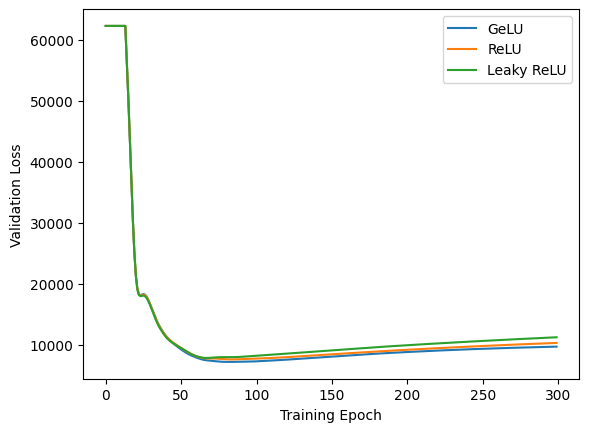

In [11]:
import matplotlib.pyplot as plt
plt.plot(val_loss[0], label='GeLU')
plt.plot(val_loss[1], label='ReLU')
plt.plot(val_loss[2], label='Leaky ReLU')
plt.xlabel('Training Epoch')
plt.ylabel('Validation Loss')
plt.legend()
#plt.savefig('mlploss.png')
plt.show()